<a href="https://colab.research.google.com/github/harnalashok/airways_project/blob/main/airways_analysis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminary

In [ ]:
# 0.0 Reset memory when repeating experiment
%reset -f

In [ ]:
# We work both in python and R

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
# 0.1 Print output from mulitple commands in a cell
# Ref: https://stackoverflow.com/a/48036735

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Call libraries
Install software and call libraries. R is used primarily for **[Data Visualization](https://github.com/harnalashok/classification/blob/main/airways_visual_analysis.ipynb)** . Nevertheless, we install and call R libraries in this notebook also.     

Connect to google drive to **save/read** results. You can skip connecting to google drive in case you do not want to **save/read** results.

In [ ]:
%%R

# R packages install. Takes time..
# R is used mainly for Data Visualization
# NEvertheless we install and call libraries in this notebook also

install.packages("tidyverse")
install.packages("vcd")
install.packages("vcdExtra")

In [ ]:
# To encode categorical features:
!pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
#1.1  Data preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, label_binarize

#1.2 Split data into X_train/X_test
from sklearn.model_selection import train_test_split

#1.3 For cross-validation and stratified k-fold partitions
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

#1.4 Encoders
#import category_encoders as ce

#1.5 For plotting/printing
import matplotlib.pyplot as plt
import seaborn as sns
# Pretty-print tabular data in Python, a
import tabulate

#1.6 Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

#1.7 Hyperparameter search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#1.8 Classification reports/metrics
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,auc,roc_curve
from sklearn.metrics import log_loss

# 1.9 Misc.
# Used in hyperparameter search & others
from scipy.stats import loguniform
import category_encoders as ce
import time
import os.path
from itertools import cycle
from pickle import load,dump

# 1.10 Statistical tests
from scipy.stats import ttest_ind
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency

In [ ]:
%%R

# Call R libraries
library(tidyverse)
library(vcd)
library(vcdExtra)

In [ ]:
#1.8 Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%R

options(warn=-1)

### Connect to google drive
We will save all results available in pandas dataframe. These can be latter retrieved and used for various reports/graphs.      
Our data directory is: `/gdrive/MyDrive/airways/`

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Read/examine data

### Read data

In [ ]:
# 2.1 Read data from github repo

df=pd.read_csv('https://raw.githubusercontent.com/harnalashok/classification/refs/heads/main/data/airways_mod_ver4.csv')
df.shape   # (1000, 13)

(1000, 13)

In [ ]:
%%R

# 2.1.1 Read data in R dataframe

df_r <- read.csv("https://raw.githubusercontent.com/harnalashok/classification/refs/heads/main/data/airways_mod_ver4.csv")

# Rename columns
colnames(df_r) <- c("age", "sex", "height", "subluxation_of_mandible", "head_and_neck_movement",
                  "buck_teeth", "edentulous", "bmi", "sternomental_distance",
                  "thyromental_distance", "mallampatti", "mouth_opening", "cormack_lehane")

# Display two rows
head(df_r,2)


  age    sex height subluxation_of_mandible head_and_neck_movement buck_teeth
1  22   male    172                       1                      0          1
2  55 female    143                       1                      0          1
  edentulous   bmi sternomental_distance thyromental_distance mallampatti
1          0 22.40                    17                  8.6           2
2          0 27.45                    16                  7.8           2
  mouth_opening cormack_lehane
1             0              2
2             0              1


In [ ]:
# 2.1.1 Data stats

df.head()
df.describe()
df.info()

,age,sex,height,subluxation of mandible,head and neck movement,buck teeth,edentulous,bmi,sternomental distance,thyromental distance,mallampatti,mouth opening,cormack lehane
0,22,male,172,1,0,1,0.0,22.40,17.0,8.6,2,0,2
1,55,female,143,1,0,1,0.0,27.45,16.0,7.8,2,0,1
2,59,male,162,2,1,0,1.0,24.20,14.3,6.9,3,0,3
3,48,female,168,1,0,0,0.0,28.50,15.6,7.2,3,0,2
4,51,female,154,3,0,0,1.0,25.30,14.3,6.7,4,1,4


,age,height,subluxation of mandible,head and neck movement,buck teeth,edentulous,bmi,sternomental distance,thyromental distance,mallampatti,mouth opening,cormack lehane
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,998.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000
mean,43.498000,163.035000,0.206000,0.104000,0.258000,0.173347,23.895350,16.935400,8.101800,1.9100,0.010000,1.826000
std,11.742823,11.470804,0.491738,0.305413,0.437753,0.378737,3.869877,1.592276,0.919566,0.6902,0.099549,0.714307
min,20.000000,132.000000,0.000000,0.000000,0.000000,0.000000,13.800000,12.500000,5.600000,1.0000,0.000000,1.000000
25%,34.000000,155.000000,0.000000,0.000000,0.000000,0.000000,21.400000,16.000000,7.500000,1.0000,0.000000,1.000000
50%,45.000000,163.000000,0.000000,0.000000,0.000000,0.000000,24.000000,17.000000,8.000000,2.0000,0.000000,2.000000
75%,54.000000,171.000000,0.000000,0.000000,1.000000,0.000000,26.525000,18.000000,8.600000,2.0000,0.000000,2.000000
max,64.000000,195.000000,3.000000,1.000000,1.000000,1.000000,37.000000,22.000000,11.000000,4.0000,1.000000,4.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1000 non-null   int64  
 1   sex                      1000 non-null   object 
 2   height                   1000 non-null   int64  
 3   subluxation of mandible  1000 non-null   int64  
 4   head and neck movement   1000 non-null   int64  
 5   buck teeth               1000 non-null   int64  
 6   edentulous               998 non-null    float64
 7   bmi                      1000 non-null   float64
 8   sternomental distance    1000 non-null   float64
 9   thyromental distance     1000 non-null   float64
 10  mallampatti              1000 non-null   int64  
 11  mouth opening            1000 non-null   int64  
 12  cormack lehane           1000 non-null   int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 101.7+ KB


Our `age` varies from 20 to 64. `bmi` ranges from 13.8 to 37. `edentulous` has two null values.

###  Recheck column names

In [ ]:
#2.2 Remove leading/trailing spaces from col names
df.columns = df.columns.str.strip()
# Within a col name keep single space
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True)  # Replaces multiple spaces with a single space
df.head()

### Drop NA rows
Only two rows get dropped. We now have 998 observations

In [ ]:
# 2.3
df.isna().sum()
# We have only two rows where edentulous is null
# Drop those rows
df = df.dropna()
# Change the type of 'edentulous' from float64 to int64
df['edentulous'] = df['edentulous'].astype('int64')
df.dtypes

,0
age,0
sex,0
height,0
subluxation of mandible,0
head and neck movement,0
buck teeth,0
edentulous,2
bmi,0
sternomental distance,0
thyromental distance,0


,0
age,int64
sex,object
height,int64
subluxation of mandible,int64
head and neck movement,int64
buck teeth,int64
edentulous,int64
bmi,float64
sternomental distance,float64
thyromental distance,float64


In [ ]:
%%R

# We do the same with dataframe in R
df_r = na.omit(df_r)
dim(df_r)   #  998  13

In [ ]:
%%R

# R: Transform cat cols to factors:

cat_cols <- c("sex", "subluxation_of_mandible", "head_and_neck_movement",
              "buck_teeth", "edentulous", "mallampatti", "mouth_opening",
              "cormack_lehane")

df_r[cat_cols] <- lapply(df_r[cat_cols], factor)
str(df_r)

'data.frame':	998 obs. of  13 variables:
 $ age                    : int  22 55 59 48 51 56 28 36 56 51 ...
 $ sex                    : Factor w/ 2 levels "female","male": 2 1 2 1 1 2 2 2 2 2 ...
 $ height                 : int  172 143 162 168 154 182 176 168 160 166 ...
 $ subluxation_of_mandible: Factor w/ 4 levels "0","1","2","3": 2 2 3 2 4 2 2 2 3 2 ...
 $ head_and_neck_movement : Factor w/ 2 levels "0","1": 1 1 2 1 1 2 1 1 1 1 ...
 $ buck_teeth             : Factor w/ 2 levels "0","1": 2 2 1 1 1 2 1 1 1 2 ...
 $ edentulous             : Factor w/ 2 levels "0","1": 1 1 2 1 2 1 1 1 2 1 ...
 $ bmi                    : num  22.4 27.4 24.2 28.5 25.3 ...
 $ sternomental_distance  : num  17 16 14.3 15.6 14.3 20 16.7 17.3 17 18 ...
 $ thyromental_distance   : num  8.6 7.8 6.9 7.2 6.7 9.7 8.3 7.9 8 8.8 ...
 $ mallampatti            : Factor w/ 4 levels "1","2","3","4": 2 2 3 3 4 2 1 1 2 2 ...
 $ mouth_opening          : Factor w/ 2 levels "0","1": 1 1 1 1 2 1 1 1 1 1 ...
 $ cormack_lehane

In [ ]:
#2.4 Map 'male' and 'female' to 1 and 0

df['sex'].value_counts()

mappings = {
            'female': 0,
            'male': 1
           }

df['sex'] = df['sex'].map(mappings)
df['sex'].value_counts()

,count
sex,
female,533
male,465


,count
sex,
0,533
1,465


In [ ]:
#2.5 Our cat features and num features:
#    (Exclude cormack lahane)

cat_features = ['sex', 'buck teeth', 'edentulous', 'mallampatti', 'mouth opening', 'subluxation of mandible', 'head and neck movement']
num_features = ["age", "height", "bmi", "sternomental distance", "thyromental distance"]

#2.6 Number of unique values in our cat features:

df[cat_features].nunique()

,0
sex,2
buck teeth,2
edentulous,2
mallampatti,4
mouth opening,2
subluxation of mandible,4
head and neck movement,2


In [ ]:
#2.7 Convert all cat-columns to 'int16' dtype

for col in cat_features:
    df[col] = df[col].astype('int16')

# Display the updated data types
df[cat_features].dtypes


,0
sex,int16
buck teeth,int16
edentulous,int16
mallampatti,int16
mouth opening,int16
subluxation of mandible,int16
head and neck movement,int16


## Data Visulaization & Statistical analysis
Understanding data and examining relationships

   



### Target distribution

In [ ]:
#2.8 Distribution of target values
# Are classes balanced?

df['cormack lehane'].value_counts()
print("")
print("\nPercent distribution")
print("===============")
df['cormack lehane'].value_counts(normalize = True)


,count
cormack lehane,
2,557
1,324
3,84
4,33




Percent distribution


,proportion
cormack lehane,
2,0.558116
1,0.324649
3,0.084168
4,0.033066


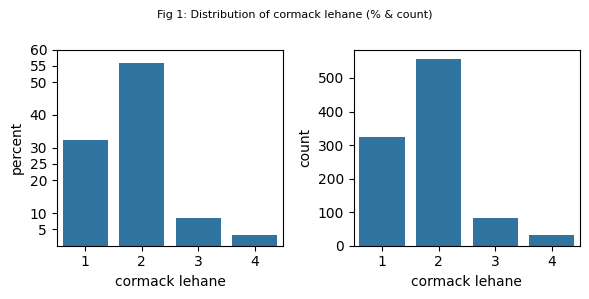

In [ ]:
#2.9 Distribution of categories in cormack lahane:
fig, axs = plt.subplots(1,2, figsize=(6, 3))
g=sns.countplot(x='cormack lehane', data=df, stat='percent', ax = axs[0])
_=g.set_yticks([5,10,20,25,30,40,50,55, 60])
_=sns.countplot(x='cormack lehane', data=df, ax = axs[1])
_=plt.suptitle('Fig 1: Distribution of cormack lehane (% & count)', fontsize = 8)
_=plt.tight_layout()
_=plt.show()

###### **Observations-1**:

>56% (count of 557) of our sample has cormack lehane of 2 and 3% (count of 33) of our sample has cormack lehane of 4.

### Distribuion of sex, cormack lehane wise

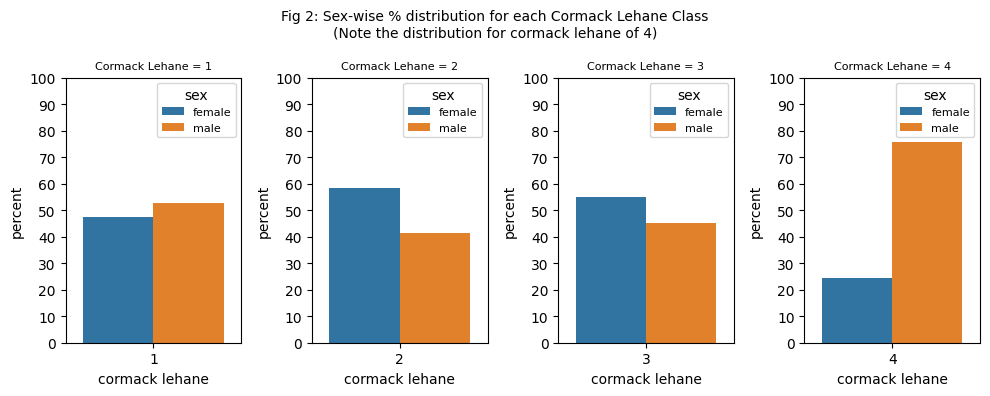

In [ ]:
# Filter data for each cormack lehane value
df_cl1 = df[df['cormack lehane'] == 1]
df_cl2 = df[df['cormack lehane'] == 2]
df_cl3 = df[df['cormack lehane'] == 3]
df_cl4 = df[df['cormack lehane'] == 4]
# Modify the labels


fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs = axs.flatten()

ax=sns.countplot(x='cormack lehane', data=df_cl1, stat='percent', hue='sex', ax=axs[0])
# Remove the default legend
_=ax.get_legend().remove()
# Add a custom legend with modified labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [label.replace('1', 'male').replace('0', 'female') for label in labels]
_=ax.legend(handles, new_labels, title="sex", fontsize = 8)
_=axs[0].set_title('Cormack Lehane = 1', fontsize = 8)
_=axs[0].set_yticks(np.arange(0, 101, 10))

ax=sns.countplot(x='cormack lehane', data=df_cl2, stat='percent', hue='sex', ax=axs[1])
# Remove the default legend
_=ax.get_legend().remove()
# Add a custom legend with modified labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [label.replace('1', 'male').replace('0', 'female') for label in labels]
_=ax.legend(handles, new_labels, title="sex" , fontsize = 8)
_=axs[1].set_title('Cormack Lehane = 2', fontsize = 8)
_=axs[1].set_yticks(np.arange(0, 101, 10))

ax=sns.countplot(x='cormack lehane', data=df_cl3, stat='percent', hue='sex', ax=axs[2])
# Remove the default legend
_=ax.get_legend().remove()
# Add a custom legend with modified labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [label.replace('1', 'male').replace('0', 'female') for label in labels]
_=ax.legend(handles, new_labels, title="sex" , fontsize = 8)
_=axs[2].set_title('Cormack Lehane = 3', fontsize = 8)
_=axs[2].set_yticks(np.arange(0, 101, 10))

ax=sns.countplot(x='cormack lehane', data=df_cl4, stat='percent', hue='sex', ax=axs[3])
# Remove the default legend
_=ax.get_legend().remove()
# Add a custom legend with modified labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [label.replace('1', 'male').replace('0', 'female') for label in labels]
_=ax.legend(handles, new_labels, title="sex" , fontsize = 8)

_=axs[3].set_title('Cormack Lehane = 4', fontsize = 8)
_=axs[3].set_yticks(np.arange(0, 101, 10))

_=plt.suptitle('Fig 2: Sex-wise % distribution for each Cormack Lehane Class\n(Note the distribution for cormack lehane of 4)', fontsize=10)
_=plt.tight_layout()
_=plt.show()

In [ ]:
# Test if for cormack lehane of 2 difference in counts of
#   male and female are statistically significant


# Filter data for cormack lehane of 2
df_cl2 = df[df['cormack lehane'] == 2]

# Create a contingency table of sex counts for cormack lehane 2
contingency_table = pd.crosstab(df_cl2['sex'], df_cl2['cormack lehane'])

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies table:")
print(expected)

# Interpret the results
alpha = 0.05  # significance level
if p < alpha:
    print("The difference in counts of male and female for Cormack Lehane of 2 is statistically significant.")
else:
    print("The difference in counts of male and female for Cormack Lehane of 2 is not statistically significant.")


Chi-squared statistic: 0.0
P-value: 1.0
Degrees of freedom: 0
Expected frequencies table:
[[326.]
 [231.]]
The difference in counts of male and female for Cormack Lehane of 2 is not statistically significant.


### Overall gender distribution

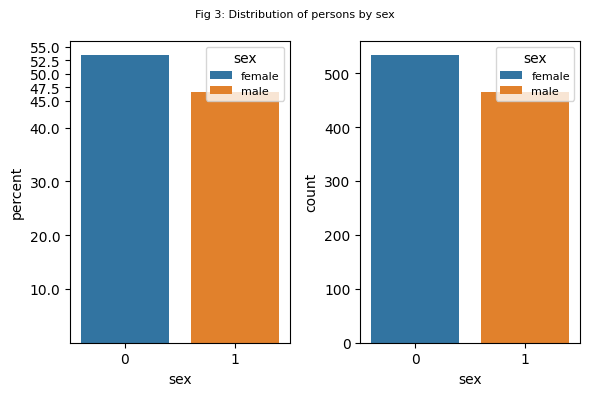

In [ ]:
# And here is overall %sex distribution
# Count-wise we have less males and more females
fig, axs = plt.subplots(1,2, figsize=(6, 4))
g=sns.countplot(x='sex', data=df, stat='percent', hue = 'sex', ax = axs[0])
_=g.set_yticks([10,20,30,40,45,47.5,50,52.5,55])
# Add a custom legend with modified labels
handles, labels = g.get_legend_handles_labels()
new_labels = [label.replace('1', 'male').replace('0', 'female') for label in labels]
_=g.legend(handles, new_labels, title="sex" , fontsize = 8)

ax=sns.countplot(x='sex', data=df, hue = 'sex', ax = axs[1])
# Remove the default legend
_=ax.get_legend().remove()
# Add a custom legend with modified labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [label.replace('1', 'male').replace('0', 'female') for label in labels]
_=ax.legend(handles, new_labels, title="sex" , fontsize = 8)
_=plt.suptitle('Fig 3: Distribution of persons by sex', fontsize = 8)
_=plt.tight_layout()
_=plt.show()

#### Mean age, sex wise
Is the mean age significantly different sex-wise?

In [ ]:
# In our data is the mean age of sex 1
#   significantly different for sex 0


# Separate the DataFrame into two groups based on sex
group_sex_0 = df[df['sex'] == 0]['age']
group_sex_1 = df[df['sex'] == 1]['age']

# Perform independent t-test
t_stat_sex, p_value_sex = ttest_ind(group_sex_0, group_sex_1)

print(f"Mean age for sex 0 (female): {group_sex_0.mean():.2f}")
print(f"Mean age for sex 1 (male): {group_sex_1.mean():.2f}")
print(f"T-statistic: {t_stat_sex:.4f}")
print(f"P-value: {p_value_sex:.4f}")

# Interpret the result
alpha = 0.05
if p_value_sex < alpha:
    print("\nConclusion: The mean ages for sex 0 and sex 1 are significantly different.")
else:
    print("\nConclusion: There is no significant difference in the mean ages for sex 0 and sex 1.")

Mean age for sex 0 (female): 43.15
Mean age for sex 1 (male): 43.88
T-statistic: -0.9843
P-value: 0.3252

Conclusion: There is no significant difference in the mean ages for sex 0 and sex 1.


#### Mean bmi, sex wise
Is the mean bmi significantly different sex-wise?

In [ ]:
# Check if the mean bmi is different sex wise


# Separate the DataFrame into two groups based on sex
group_sex_0 = df[df['sex'] == 0]['bmi']
group_sex_1 = df[df['sex'] == 1]['bmi']

# Perform independent t-test
t_stat_bmi, p_value_bmi = ttest_ind(group_sex_0, group_sex_1)

print(f"Mean BMI for sex 0 (female): {group_sex_0.mean():.2f}")
print(f"Mean BMI for sex 1 (male): {group_sex_1.mean():.2f}")
print(f"T-statistic: {t_stat_bmi:.4f}")
print(f"P-value: {p_value_bmi:.4f}")

# Interpret the result
alpha = 0.05
if p_value_bmi < alpha:
    print("\nConclusion: The mean BMIs for sex 0 and sex 1 are significantly different.")
else:
    print("\nConclusion: There is no significant difference in the mean BMIs for sex 0 and sex 1.")

Mean BMI for sex 0 (female): 24.03
Mean BMI for sex 1 (male): 23.76
T-statistic: 1.1093
P-value: 0.2676

Conclusion: There is no significant difference in the mean BMIs for sex 0 and sex 1.


###### **Observations-2**

>1. Countwise, in our sample, there are more females than males.


>2. Mean age of females and males is not significantly different.  

>3. There is no significant difference in the mean BMIs for males and females.    

>4. Most of those who have cormack lehane of 4 are men.

### Distribution of individual categorical features

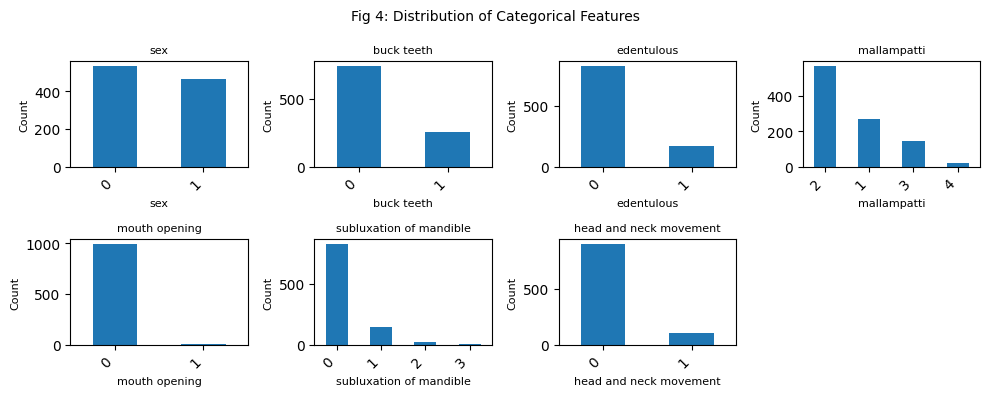

In [ ]:
# Distribution of categorical features:
fig, axes = plt.subplots(2, 4, figsize=(10, 4))
_=fig.suptitle('Fig 4: Distribution of Categorical Features', fontsize=10)

for i, col in enumerate(cat_features):
    ax = axes[i // 4, i % 4]
    _=df[col].value_counts().plot(kind='bar', ax=ax)
    _=ax.set_title(col, fontsize=8)
    _=ax.set_xlabel(col, fontsize=8)
    _=ax.set_ylabel('Count', fontsize=8)
    _=plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    if i == 6:
       _=plt.axis('off')

_=plt.tight_layout()
_=plt.show()

###### **Observations-3**

>1. `sex` has almost balanced distribution with females being higher in numbers. There is no significant difference in mean `age` of men and of women in our data

>2. For `buck teeth`, level 2 is very rare. For `mouth opening` level 1 is rare, so also level 3 for `subluxation of mandible`.

### Distribution of numeric features
With gender, cormack lehane and sex

#### With gender

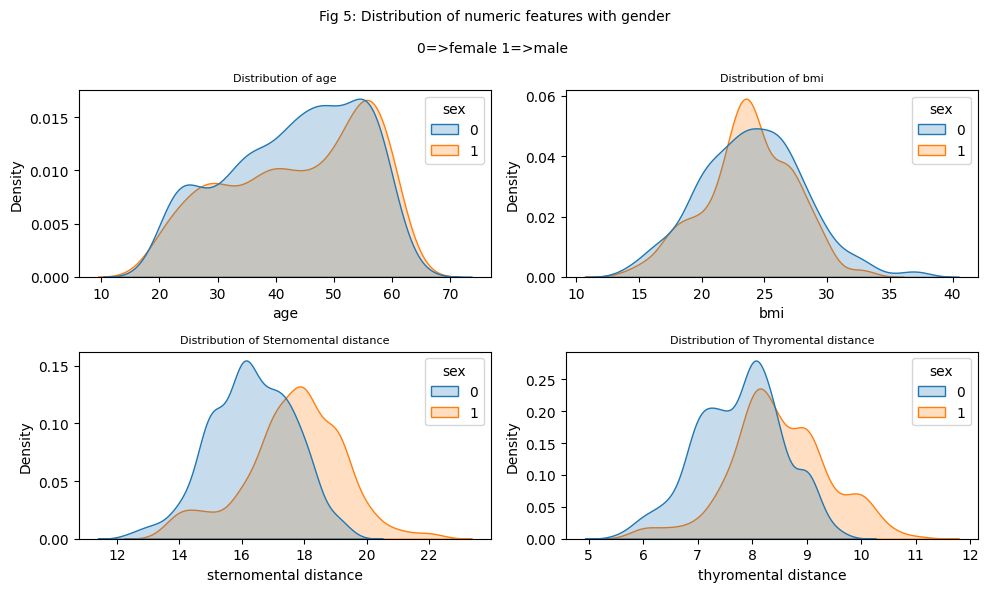

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(10, 6))
_=plt.suptitle('Fig 5: Distribution of numeric features with gender\n\n0=>female 1=>male ', fontsize=10)
_=sns.kdeplot(data = df, x = "age", hue ='sex', ax =axs[0,0], fill=True)
_=axs[0,0].set_title("Distribution of age", fontsize = 8)
_=sns.kdeplot(data = df, x ="bmi" , hue = 'sex', ax =axs[0,1], fill = True)
_=axs[0,1].set_title("Distribution of bmi", fontsize = 8)
_=sns.kdeplot(data = df, x = "sternomental distance", hue ='sex', ax =axs[1,0], fill=True)
_=axs[1,0].set_title("Distribution of Sternomental distance", fontsize = 8)
_=sns.kdeplot(data = df, x = "thyromental distance" , hue = 'sex', ax =axs[1,1], fill = True)
_=axs[1,1].set_title("Distribution of Thyromental distance", fontsize = 8)
_=plt.tight_layout()
_=plt.show()


#### With sternomental distance > 18

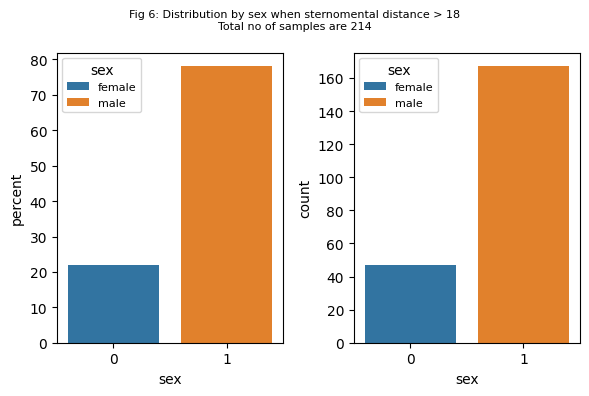

In [ ]:
# When sternomental distance > 18
filtered_df = df.loc[df['sternomental distance'] >18 , : ]
# Most of those who have sternomental distance > 18 are men
fig, axs = plt.subplots(1,2, figsize=(6, 4))
ax=sns.countplot(x='sex', data=filtered_df, stat='percent', hue = 'sex', ax = axs[0])
# Remove the default legend
_=ax.get_legend().remove()
# Add a custom legend with modified labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [label.replace('1', 'male').replace('0', 'female') for label in labels]
_=ax.legend(handles, new_labels, title="sex" , fontsize = 8)
ax=sns.countplot(x='sex', data=filtered_df, hue = 'sex', ax = axs[1])
# Remove the default legend
_=ax.get_legend().remove()
# Add a custom legend with modified labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [label.replace('1', 'male').replace('0', 'female') for label in labels]
_=ax.legend(handles, new_labels, title="sex" , fontsize = 8)
_=plt.suptitle(f'Fig 6: Distribution by sex when sternomental distance > 18\nTotal no of samples are {filtered_df.shape[0]}', fontsize = 8)
_=plt.tight_layout()
_=plt.show()

##### strenomental distance vs age
Any relationship between the two?

In [ ]:
# Does mean age for strenomental distance (smd) < 18 and
#  mean age for strenomental distance (smd) > 18
#   are significantly diffenet

# Separate the DataFrame into two groups based on sternomental distance
group_le_18 = df[df['sternomental distance'] <= 18]['age']
group_gt_18 = df[df['sternomental distance'] > 18]['age']

# Perform independent t-test
t_stat, p_value = ttest_ind(group_le_18, group_gt_18)

print(f"Mean age for sternomental distance <= 18: {group_le_18.mean():.2f}")
print(f"Mean age for sternomental distance > 18: {group_gt_18.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: The mean ages for the two groups are significantly different.")
else:
    print("\nConclusion: There is no significant difference in the mean ages for the two groups.")


Mean age for sternomental distance <= 18: 44.57
Mean age for sternomental distance > 18: 39.55
T-statistic: 5.6196
P-value: 0.0000

Conclusion: The mean ages for the two groups are significantly different.


##### strenomental distance vs sex
Any relationship between the two?

In [ ]:
# Is the mean strenomental distance sex wise is different

# Separate the DataFrame into two groups based on sex
group_sex_0_smd = df[df['sex'] == 0]['sternomental distance']
group_sex_1_smd = df[df['sex'] == 1]['sternomental distance']

# Perform independent t-test
from scipy.stats import ttest_ind
t_stat_smd, p_value_smd = ttest_ind(group_sex_0_smd, group_sex_1_smd)

print(f"Mean sternomental distance for sex 0 (female): {group_sex_0_smd.mean():.2f}")
print(f"Mean sternomental distance for sex 1 (male): {group_sex_1_smd.mean():.2f}")
print(f"T-statistic: {t_stat_smd:.4f}")
print(f"P-value: {p_value_smd:.4f}")

# Interpret the result
alpha = 0.05
if p_value_smd < alpha:
    print("\nConclusion: The mean sternomental distances for sex 0 and sex 1 are significantly different.")
else:
    print("\nConclusion: There is no significant difference in the mean sternomental distances for sex 0 and sex 1.")


Mean sternomental distance for sex 0 (female): 16.32
Mean sternomental distance for sex 1 (male): 17.65
T-statistic: -14.5491
P-value: 0.0000

Conclusion: The mean sternomental distances for sex 0 and sex 1 are significantly different.


##### strenomental distance < 18 vs age
Is the mean age of males and females for strenomental distance < 18

In [ ]:
# For strenomental distance less than 18
#   is the mean age of sex of males (1)
#     significantly different from that of females (0)

from scipy.stats import ttest_ind

# Filter the DataFrame for sternomental distance less than 18
filtered_df_smd_le_18 = df[df['sternomental distance'] < 18]

# Separate the filtered DataFrame into two groups based on sex
group_smd_le_18_sex_0 = filtered_df_smd_le_18[filtered_df_smd_le_18['sex'] == 0]['age']
group_smd_le_18_sex_1 = filtered_df_smd_le_18[filtered_df_smd_le_18['sex'] == 1]['age']

# Perform independent t-test
t_stat_smd_le_18, p_value_smd_le_18 = ttest_ind(group_smd_le_18_sex_0, group_smd_le_18_sex_1)

print(f"For sternomental distance < 18: ")
print(f"Sample size is: {filtered_df_smd_le_18.shape[0]}")
print(f"males: {group_smd_le_18_sex_1.shape[0]} females: {group_smd_le_18_sex_0.shape[0]}")
print(f"Mean age for sex 0 (female): {group_smd_le_18_sex_0.mean():.2f}")
print(f"Mean age for sex 1 (male): {group_smd_le_18_sex_1.mean():.2f}")
print(f"T-statistic: {t_stat_smd_le_18:.4f}")
print(f"P-value: {p_value_smd_le_18:.4f}")

# Interpret the result
alpha = 0.05
if p_value_smd_le_18 < alpha:
    print("\nConclusion: The mean ages for sex 0 and sex 1 are significantly different for sternomental distance < 18.")
else:
    print("\nConclusion: There is no significant difference in the mean ages for sex 0 and sex 1 for sternomental distance < 18.")

For sternomental distance < 18: 
Sample size is: 692
males: 227 females: 465
Mean age for sex 0 (female): 43.32
Mean age for sex 1 (male): 46.59
T-statistic: -3.5288
P-value: 0.0004

Conclusion: The mean ages for sex 0 and sex 1 are significantly different for sternomental distance < 18.


##### strenomental distance > 18 vs age
Is the mean age of males and females for strenomental distance > 18

In [ ]:
# For strenomental distance greater than 18
#   is the mean age of sex of males (1)
#     significantly different from that of females (0)

# Filter the DataFrame for sternomental distance greater than 18
filtered_df_smd_le_18 = df[df['sternomental distance'] > 18]

# Separate the filtered DataFrame into two groups based on sex
group_smd_le_18_sex_0 = filtered_df_smd_le_18[filtered_df_smd_le_18['sex'] == 0]['age']
group_smd_le_18_sex_1 = filtered_df_smd_le_18[filtered_df_smd_le_18['sex'] == 1]['age']

# Perform independent t-test
t_stat_smd_le_18, p_value_smd_le_18 = ttest_ind(group_smd_le_18_sex_0, group_smd_le_18_sex_1)

print(f"For sternomental distance > 18:")
print(f"Sample size is: {filtered_df_smd_le_18.shape[0]}")
print(f"males: {group_smd_le_18_sex_1.shape[0]} females: {group_smd_le_18_sex_0.shape[0]}")
print(f"Mean age for sex 0 (female): {group_smd_le_18_sex_0.mean():.2f}")
print(f"Mean age for sex 1 (male): {group_smd_le_18_sex_1.mean():.2f}")
print(f"T-statistic: {t_stat_smd_le_18:.4f}")
print(f"P-value: {p_value_smd_le_18:.4f}")

# Interpret the result
alpha = 0.05
if p_value_smd_le_18 < alpha:
    print("\nConclusion: The mean ages for sex 0 and sex 1 are significantly different for sternomental distance > 18.")
else:
    print("\nConclusion: There is no significant difference in the mean ages for sex 0 and sex 1 for sternomental distance > 18.")

For sternomental distance > 18:
Sample size is: 214
males: 167 females: 47
Mean age for sex 0 (female): 41.68
Mean age for sex 1 (male): 38.95
T-statistic: 1.3422
P-value: 0.1810

Conclusion: There is no significant difference in the mean ages for sex 0 and sex 1 for sternomental distance > 18.


#### Distribution of num features subsetted by sex and cormack lehane

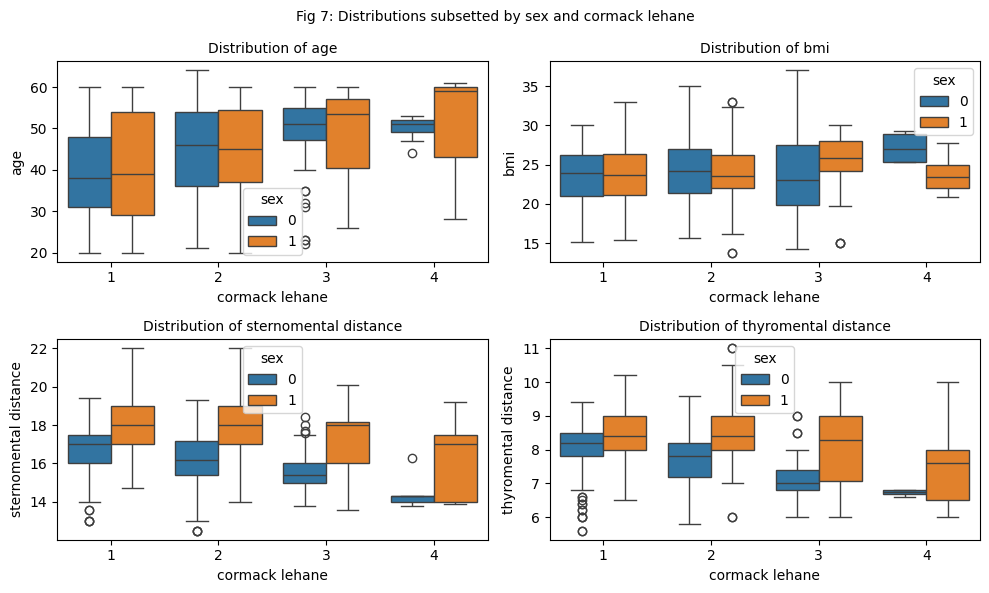

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(10, 6))
_=fig.suptitle('Fig 7: Distributions subsetted by sex and cormack lehane', fontsize=10)
fx=sns.boxplot(data=df, x="cormack lehane", y="age", hue="sex", ax=axs[0,0])
_=fx.set_title("Distribution of age" , fontsize=10)
fx=sns.boxplot(data=df, x="cormack lehane", y="bmi", hue="sex", ax=axs[0,1])
_=fx.set_title("Distribution of bmi", fontsize=10)
fx=sns.boxplot(data=df, x="cormack lehane", y="sternomental distance", hue="sex", ax=axs[1,0])
_=fx.set_title("Distribution of sternomental distance", fontsize=10)
fx=sns.boxplot(data=df, x="cormack lehane", y="thyromental distance", hue="sex", ax=axs[1,1])
fx=fx.set_title("Distribution of thyromental distance", fontsize=10)
_=plt.tight_layout()
_=plt.show()

###### **Observations-4**

>1. `age` wise and `bmi` wise distribution among females and males is almost the same. For `bmi`, we have a flatter density curve for females around the mean as compared to males.   

>2. However, distribution of both `Sternomental distances` and of `Thyromental distances` slide towards right for males--In the case of `Sternomental distances` means for male and female are clearly distinguishable. This behaviour can be seen on prononced basis in the box plots above. Also see bar plots below.     

>3. Mean `age` for strenomental distance less than 18 and that for strenomental distance greater than 18 is significantly different.   

>4. For `strenomental distance` less than 18, mean `age` for females is significantly different from that of males. However, for `strenomental distance` greater than 18 mean `age` of male and that of female is not significantly different.   


>3. `Cormack lehane` of 4 occurs mostly in males rather than in females

### Categorical feature relationships
See these links:  [one](https://stats.stackexchange.com/questions/266001/how-to-determine-significant-associations-in-a-mosaic-plot)  and [two](https://stats.stackexchange.com/a/147864) and [three](https://www.datacamp.com/tutorial/contingency-tables-r)

We look at relationships of categorical features with the target (`cormack lehane`) as also within categocrial features themselves.

#### Mosaic plots and Pearson Residuals
See this good [reference](https://www.datavis.ca/papers/drew/) and this [book](http://euclid.psych.yorku.ca/www/psy6136/ClassOnly/VCDR/book2.pdf) (pages 164..)

##### **What are mosaic plots?**

>A mosaic plot is a visual representation of the association between two or more categorical variables. It's a rectangular area subdivided into smaller rectangular tiles, with the size of each tile proportional to the observed frequency (or count) of a cell in the contingency table. The mosaic display (Friendly, 1992, 1994b, 1997, Hartigan and Kleiner, 1981, 1984) is like a
grouped barchart, where the heights (or widths) of the bars show the relative frequencies of one variable, and widths (heights) of the sections in each bar show the conditional frequencies of the second variable, given the first. This gives an area-proportional visualization of the frequencies.

>The plot uses color or shading to highlight deviations from expected frequencies, helping to reveal patterns and relationships in the data.  

>Mosaic plot can aometimes be also thought as percent stacked bar plot--a graphical visualization of data from two or more qualitative variables.      

>The default color scheme uses red for negative residuals and blue for positive residuals, with darker shades indicating higher absolute residual values.

##### **Chisquare** test calculations from [Wikipedia](https://en.wikipedia.org/wiki/Chi-squared_test) are as below.       
>Also may see this [Khan Academy](https://www.khanacademy.org/math/statistics-probability/inference-categorical-data-chi-square-tests/chi-square-tests-for-homogeneity-and-association-independence/v/contingency-table-chi-square-test) video at this [link](https://www.khanacademy.org/math/statistics-probability/inference-categorical-data-chi-square-tests/chi-square-tests-for-homogeneity-and-association-independence/v/contingency-table-chi-square-test).

>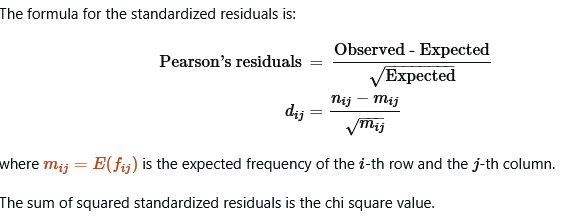

##### mallampatti vs cormack lehane

Contigency table
           cormack_lehane
mallampatti   1   2   3   4
          1 156  98  15   0
          2 154 367  35  12
          3   7  92  27  17
          4   7   0   7   4


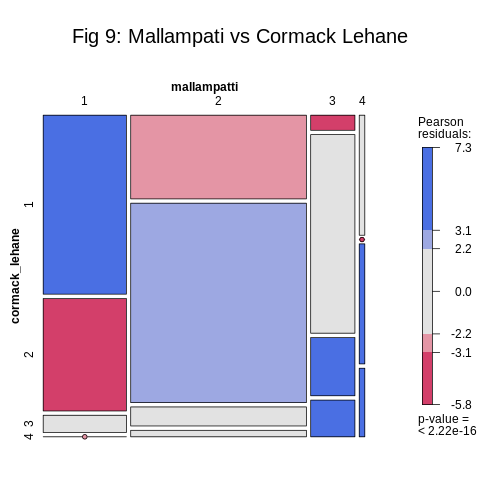

In [ ]:
%%R

# Mosaic plot of mallampatti vs cormack lehane
art <- xtabs(~mallampatti + cormack_lehane, data = df_r)

cat("Contigency table\n")
cat("==============\n")
print(art)

mosaic(art,
       gp = shading_max,
       split_vertical = TRUE,
       main="Fig 9: Mallampati vs Cormack Lehane"
       )

Contigency table
           cormack_lehane
mallampatti   1   2   3   4
          1 156  98  15   0
          2 154 367  35  12
          3   7  92  27  17


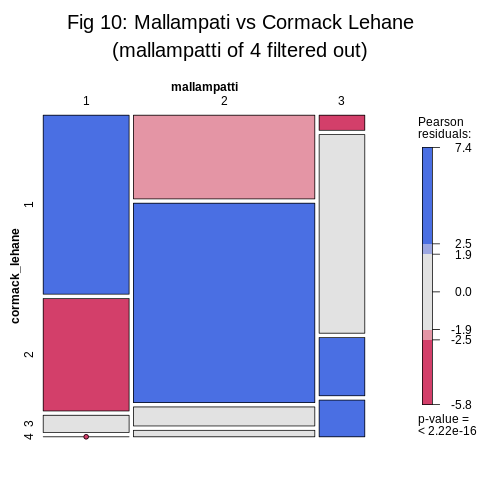

In [ ]:
%%R

# Mosaic plot of mallampatti vs cormacl lehane
# Even when I filter out mallampatti of 4
temp<-df_r %>% filter(mallampatti != 4)
temp$mallampatti <- temp$mallampatti[ , drop=TRUE]

art <- xtabs(~mallampatti + cormack_lehane, data = temp)

cat("Contigency table\n")
cat("==============\n")
print(art)

mosaic(art,
       gp = shading_max,
       split_vertical = TRUE,
       main="Fig 10: Mallampati vs Cormack Lehane\n(mallampatti of 4 filtered out)"
       )

In [ ]:
# Chisquare test to check if mallampatti and cormack lehane are independent

# Create a contingency table of Mallampati and Cormack Lehane scores
contingency_table = pd.crosstab(df['mallampatti'], df['cormack lehane'])

# Perform the Chi-square test for independence
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square test results:")
print("========================")
print(f"Contingency Table:\n{contingency_table}")
print(f"\nChi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
# print(f"Expected frequencies:\n{expected}") # Uncomment to see expected frequencies

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: The Chi-square test indicates a significant association between Mallampati and Cormack Lehane scores (reject null hypothesis of independence).")
else:
    print("\nConclusion: The Chi-square test does not indicate a significant association between Mallampati and Cormack Lehane scores (fail to reject null hypothesis of independence).")


Chi-square test results:
Contingency Table:
cormack lehane    1    2   3   4
mallampatti                     
1               156   98  15   0
2               154  367  35  12
3                 7   92  27  17
4                 7    0   7   4

Chi-square statistic: 237.7509
P-value: 0.0000
Degrees of freedom: 9

Conclusion: The Chi-square test indicates a significant association between Mallampati and Cormack Lehane scores (reject null hypothesis of independence).


###### **Observations-5**

>`mallampatti` and `cormack lehane` are not independent. Null hypothesis of independence is rejected.

>1. People with mallampatti score of 1 tend to have cormack lehane of 1     
>2. People with mallampatti score of 2 tend to have cormack lehane of 2   
>3. Among those who have cormack_lehane of 4, most have mallamapatti of 3 or 2
         

In [ ]:
# We can verify that among those who have cormack lehane of 4,
#   most have mallampatti of 3 or 2

# Filter the DataFrame to include only rows where 'cormack lehane' is 4
df_cl4 = df[df['cormack lehane'] == 4]

# Get the distribution of 'mallampatti' for this filtered DataFrame
mallampatti_distribution_cl4 = df_cl4['mallampatti'].value_counts()

print("Distribution of Mallampatti among those with Cormack Lehane of 4:")
mallampatti_distribution_cl4

Distribution of Mallampatti among those with Cormack Lehane of 4:


,count
mallampatti,
3,17
2,12
4,4


##### sex vs cormack lehane

Contigency table
        cormack_lehane
sex        1   2   3   4
  female 153 326  46   8
  male   171 231  38  25


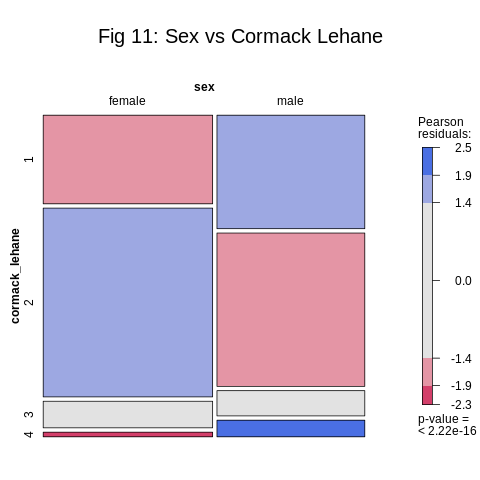

In [ ]:
%%R

# Mosaic plot of sex vs cormack lehane
art <- xtabs(~sex + cormack_lehane, data = df_r)

cat("Contigency table\n")
cat("==============\n")
print(art)

mosaic(art,
       gp = shading_max,
       split_vertical = TRUE,
       main="Fig 11: Sex vs Cormack Lehane"
       )

In [ ]:
# Chisquare test to check if sex and cormak lehane are independent

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import pandas as pd

# Create a contingency table of Sex and Cormack Lehane scores
contingency_table_sex_cl = pd.crosstab(df['sex'], df['cormack lehane'])

# Perform the Chi-square test for independence
chi2_stat_sex_cl, p_value_sex_cl, dof_sex_cl, expected_sex_cl = chi2_contingency(contingency_table_sex_cl)

print("\nChi-square test results for Sex and Cormack Lehane:")
print("===============================================")
print(f"Contingency Table:\n{contingency_table_sex_cl}")
print(f"\nChi-square statistic: {chi2_stat_sex_cl:.4f}")
print(f"P-value: {p_value_sex_cl:.4f}")
print(f"Degrees of freedom: {dof_sex_cl}")

# Interpret the result
alpha = 0.05
if p_value_sex_cl < alpha:
    print("\nConclusion: The Chi-square test indicates a significant association between Sex and Cormack Lehane scores (reject null hypothesis of independence).")
else:
    print("\nConclusion: The Chi-square test does not indicate a significant association between Sex and Cormack Lehane scores (fail to reject null hypothesis of independence).")


Chi-square test results for Sex and Cormack Lehane:
Contingency Table:
cormack lehane    1    2   3   4
sex                             
0               153  326  46   8
1               171  231  38  25

Chi-square statistic: 22.1921
P-value: 0.0001
Degrees of freedom: 3

Conclusion: The Chi-square test indicates a significant association between Sex and Cormack Lehane scores (reject null hypothesis of independence).


###### **Observations-6**

>`sex` and `cormack lehane` have dependency
>1. Females tend to have cormack lehane of 2      
>2. Among those who have cormack lehane of 4, more are males.

In [ ]:
# We can verify if females (sex of 0) tend to have cormack lehane of 2

# Filter the DataFrame to include only rows where 'sex' is 0 (female) and 'cormack lehane' is 2
filtered_df_sex_0_cl_2 = df[(df['sex'] == 0) & (df['cormack lehane'] == 2)]

# Get the total number of females
total_females = df[df['sex'] == 0].shape[0]

# Get the number of females with cormack lehane of 2
females_cl_2_count = filtered_df_sex_0_cl_2.shape[0]

# Calculate the percentage
percentage_females_cl_2 = (females_cl_2_count / total_females) * 100 if total_females > 0 else 0

print(f"Number of females (sex=0): {total_females}")
print(f"Number of females with Cormack Lehane of 2: {females_cl_2_count}")
print(f"Percentage of females with Cormack Lehane of 2: {percentage_females_cl_2:.2f}%")

# You can also directly look at the percentage distribution for Cormack Lehane within the female group
df_females = df[df['sex'] == 0]
cormack_lehane_distribution_females = df_females['cormack lehane'].value_counts(normalize=True) * 100

print("\nPercentage distribution of Cormack Lehane among females:")
cormack_lehane_distribution_females

# Visual confirmation from the mosaic plot (Fig 11) and bar plot (Fig 2)
# Fig 11 shows a positive association (blue shading) between sex=0 (female) and cormack_lehane=2.
# Fig 2 (second subplot) visually confirms that a large percentage of females have cormack lehane = 2.


Number of females (sex=0): 533
Number of females with Cormack Lehane of 2: 326
Percentage of females with Cormack Lehane of 2: 61.16%

Percentage distribution of Cormack Lehane among females:


,proportion
cormack lehane,
2,61.163227
1,28.705441
3,8.630394
4,1.500938


##### mouth_opening vs cormack lehane

Contigency table
             cormack_lehane
mouth_opening   1   2   3   4
            0 324 551  84  29
            1   0   6   0   4


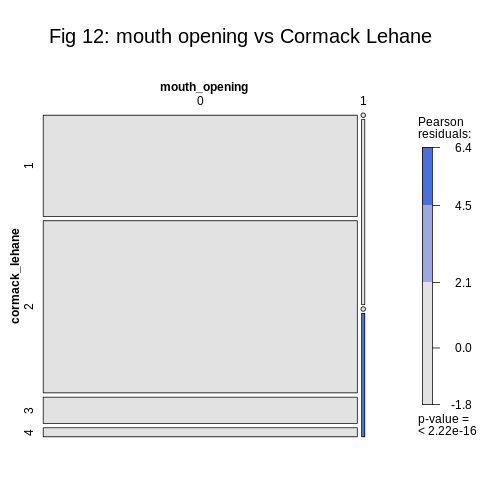

In [ ]:
%%R

# Mosaic plot of mouth_opening vs cormack lehane
art <- xtabs(~mouth_opening + cormack_lehane, data = df_r)

cat("Contigency table\n")
cat("==============\n")
print(art)

mosaic(art,
       gp = shading_max,
       split_vertical = TRUE,
       main="Fig 12: mouth opening vs Cormack Lehane"
       )

In [ ]:
# Perform fisher test to check if mouth opening  and cormack lehane are independent


# Create a contingency table of mouth opening and Cormack Lehane scores
contingency_table_mouth_cl = pd.crosstab(df['mouth opening'], df['cormack lehane'])

# Perform the Fisher's exact test for independence
# Note: Fisher's exact test is typically used for 2x2 tables or tables with small expected frequencies.
# For larger tables like this one, the chi-square test is more commonly used and provides similar results
# if expected frequencies are large enough. However, the request specifically asks for Fisher's test.
# scipy's fisher_exact can handle larger tables but is computationally more intensive.

# For a standard Fisher's exact test (like in R), you'd need a 2x2 table.
# To apply it to a larger table, you'd typically test independence for each cell or combine categories.
# Let's perform the test on the full table as scipy allows it.

# Note: The `fisher_exact` function in scipy returns the odd ratio and the p-value.
# The p-value tests the null hypothesis that the rows and columns are independent.
odds_ratio, p_value_fisher = fisher_exact(contingency_table_mouth_cl)

print("\nFisher's Exact Test results for Mouth Opening and Cormack Lehane:")
print("=======================================================")
print(f"Contingency Table:\n{contingency_table_mouth_cl}")
print(f"\nOdds Ratio: {odds_ratio:.4f}") # Interpretation of odds ratio is complex for tables larger than 2x2
print(f"P-value: {p_value_fisher:.4f}")

# Interpret the result based on the p-value
alpha = 0.05
if p_value_fisher < alpha:
    print("\nConclusion: Fisher's exact test indicates a significant association between Mouth Opening and Cormack Lehane scores (reject null hypothesis of independence).")
else:
    print("\nConclusion: Fisher's exact test does not indicate a significant association between Mouth Opening and Cormack Lehane scores (fail to reject null hypothesis of independence).")




Fisher's Exact Test results for Mouth Opening and Cormack Lehane:
Contingency Table:
cormack lehane    1    2   3   4
mouth opening                   
0               324  551  84  29
1                 0    6   0   4

Odds Ratio: 0.0000
P-value: 0.0001

Conclusion: Fisher's exact test indicates a significant association between Mouth Opening and Cormack Lehane scores (reject null hypothesis of independence).


###### **Observations-7**

>As per p-value `mouth opening` and `cormack lehane` appear to be dependent. But, as counts for mouth opening 1 are few, this observation is a suspect.

##### edentulous vs cormack lehane

Contigency table
          cormack_lehane
edentulous   1   2   3   4
         0 284 456  63  22
         1  40 101  21  11


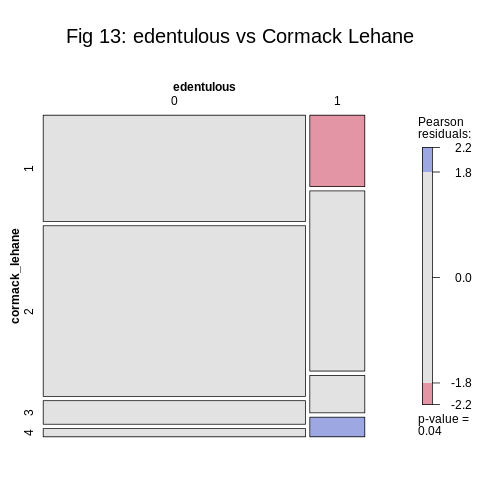

In [ ]:
%%R
# Mosaic plot of edentulous vs cormack lehane
art <- xtabs(~edentulous + cormack_lehane, data = df_r)

cat("Contigency table\n")
cat("==============\n")
print(art)

mosaic(art,
       gp = shading_max,
       split_vertical = TRUE,
       main="Fig 13: edentulous vs Cormack Lehane"
       )

In [ ]:
# Perform Chi-square test to check if cormack lehane and edentulous are associated or independent

# Create a contingency table of edentulous status and Cormack Lehane scores
contingency_table_edentulous_cl = pd.crosstab(df['edentulous'], df['cormack lehane'])

# Perform the Chi-square test for independence
chi2_stat_edentulous_cl, p_value_edentulous_cl, dof_edentulous_cl, expected_edentulous_cl = chi2_contingency(contingency_table_edentulous_cl)

print("\nChi-square test results for Edentulous status and Cormack Lehane:")
print("===========================================================")
print(f"Contingency Table:\n{contingency_table_edentulous_cl}")
print(f"\nChi-square statistic: {chi2_stat_edentulous_cl:.4f}")
print(f"P-value: {p_value_edentulous_cl:.4f}")
print(f"Degrees of freedom: {dof_edentulous_cl}")
# print(f"Expected frequencies:\n{expected_edentulous_cl}") # Uncomment to see expected frequencies

# Interpret the result
alpha = 0.05
if p_value_edentulous_cl < alpha:
    print("\nConclusion: The Chi-square test indicates a significant association between Edentulous status and Cormack Lehane scores (reject null hypothesis of independence).")
else:
    print("\nConclusion: The Chi-square test does not indicate a significant association between Edentulous status and Cormack Lehane scores (fail to reject null hypothesis of independence).")




Chi-square test results for Edentulous status and Cormack Lehane:
Contingency Table:
cormack lehane    1    2   3   4
edentulous                      
0               284  456  63  22
1                40  101  21  11

Chi-square statistic: 15.2141
P-value: 0.0016
Degrees of freedom: 3

Conclusion: The Chi-square test indicates a significant association between Edentulous status and Cormack Lehane scores (reject null hypothesis of independence).


###### **Observations-8**

>`edentulous` and `cormack lehane` are dependent.

##### buck_teeth vs cormack lehane

Contigency table
          cormack_lehane
buck_teeth   1   2   3   4
         0 240 425  51  24
         1  84 132  33   9


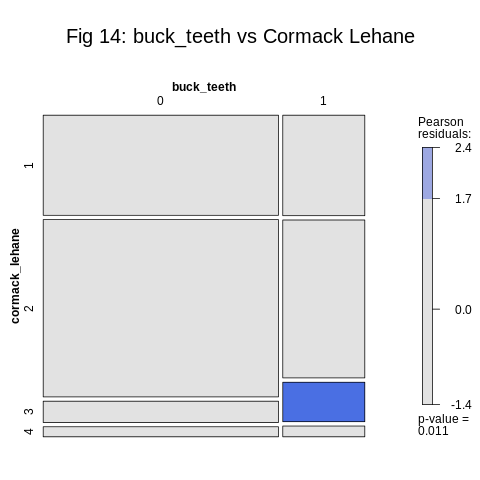

In [ ]:
%%R

# Mosaic plot of buck_teeth vs cormack lehane

art <- xtabs(~buck_teeth + cormack_lehane, data = df_r)
cat("Contigency table\n")
cat("==============\n")
print(art)



mosaic(art,
       gp = shading_max,
       split_vertical = TRUE,
       main="Fig 14: buck_teeth vs Cormack Lehane"
       )

In [ ]:
# Check using fisher test if cormack lehane and buck teeth are associated

import pandas as pd
from scipy.stats import fisher_exact

# Create a contingency table of cormack lehane and buck teeth
contingency_table_cl_bt = pd.crosstab(df['cormack lehane'], df['buck teeth'])

# Perform the Fisher's exact test for independence
# Note: scipy's fisher_exact can handle larger tables, but it's primarily designed and most interpretable for 2x2 tables.
# The p-value tests the null hypothesis that the rows and columns are independent.
odds_ratio, p_value_cl_bt = fisher_exact(contingency_table_cl_bt)

print("\nFisher's Exact Test results for Cormack Lehane and Buck Teeth:")
print("=========================================================")
print(f"Contingency Table:\n{contingency_table_cl_bt}")
print(f"\nOdds Ratio: {odds_ratio:.4f}") # Interpretation of odds ratio is complex for tables larger than 2x2
print(f"P-value: {p_value_cl_bt:.4f}")

# Interpret the result based on the p-value
alpha = 0.05
if p_value_cl_bt < alpha:
    print("\nConclusion: Fisher's exact test indicates a significant association between Cormack Lehane and Buck Teeth (reject null hypothesis of independence).")
else:
    print("\nConclusion: Fisher's exact test does not indicate a significant association between Cormack Lehane and Buck Teeth (fail to reject null hypothesis of independence).")


Fisher's Exact Test results for Cormack Lehane and Buck Teeth:
Contingency Table:
buck teeth        0    1
cormack lehane          
1               240   84
2               425  132
3                51   33
4                24    9

Odds Ratio: 0.0000
P-value: 0.0291

Conclusion: Fisher's exact test indicates a significant association between Cormack Lehane and Buck Teeth (reject null hypothesis of independence).


###### **Observations-9**

>Both buck_teeth and cormack lehane are not independent

##### subluxation_of_mandible vs cormack lehane

Contigency table
                       cormack_lehane
subluxation_of_mandible   1   2   3   4
                      0 279 471  59  17
                      1  38  81  14  10
                      2   7   5   9   3
                      3   0   0   2   3


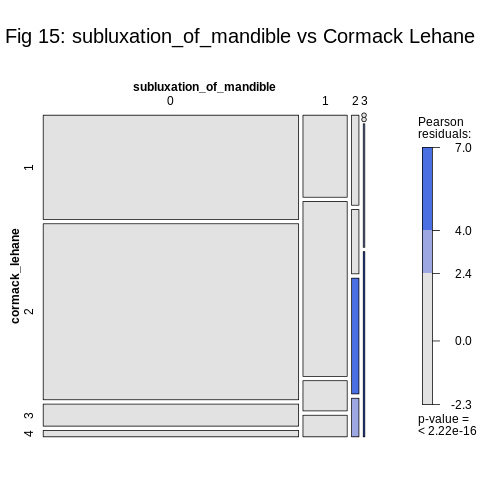

In [ ]:
%%R

# Mosaic plot of subluxation_of_mandible vs cormack lehane
art <- xtabs(~subluxation_of_mandible + cormack_lehane, data = df_r)

cat("Contigency table\n")
cat("==============\n")
print(art)


mosaic(art,
       gp = shading_max,
       split_vertical = TRUE,
       main="Fig 15: subluxation_of_mandible vs Cormack Lehane")

Contigency table
                       cormack_lehane
subluxation_of_mandible   1   2   3   4
                      0 279 471  59  17
                      1  38  81  14  10
                      2   7   5   9   3


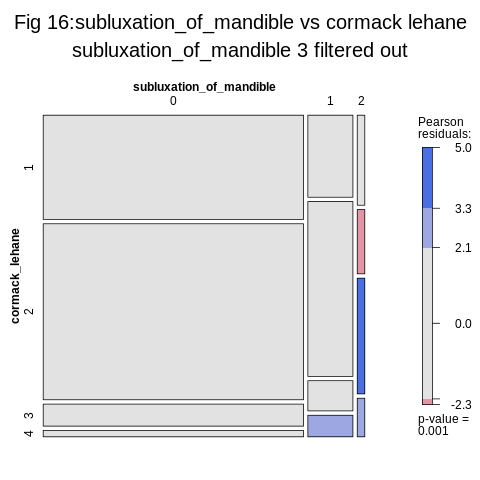

In [ ]:
%%R

# Mosaic plot of subluxation_of_mandible vs cormack lehane

# Filtering out subluxation_of_mandible of 3
temp<-df_r %>% filter(subluxation_of_mandible != 3)
temp$subluxation_of_mandible <- temp$subluxation_of_mandible[ , drop=TRUE]


art <- xtabs(~subluxation_of_mandible + cormack_lehane, data = temp)

cat("Contigency table\n")
cat("==============\n")
print(art)


mosaic(art,
       gp = shading_max,
       split_vertical = TRUE,
       main="Fig 16:subluxation_of_mandible vs cormack lehane\nsubluxation_of_mandible 3 filtered out")

In [ ]:
# Check using Fishers test if subluxation of mandible and cormack lehane are associated

# Create a contingency table of subluxation of mandible and Cormack Lehane scores
contingency_table_sublux_cl = pd.crosstab(df['subluxation of mandible'], df['cormack lehane'])

# Perform the Fisher's exact test for independence
# Note: scipy's fisher_exact can handle larger tables, but it's primarily designed and most interpretable for 2x2 tables.
# The p-value tests the null hypothesis that the rows and columns are independent.
odds_ratio, p_value_sublux_cl = fisher_exact(contingency_table_sublux_cl)

print("\nFisher's Exact Test results for Subluxation of Mandible and Cormack Lehane:")
print("=====================================================================")
print(f"Contingency Table:\n{contingency_table_sublux_cl}")
print(f"\nOdds Ratio: {odds_ratio:.4f}") # Interpretation of odds ratio is complex for tables larger than 2x2
print(f"P-value: {p_value_sublux_cl:.4f}")

# Interpret the result based on the p-value
alpha = 0.05
if p_value_sublux_cl < alpha:
    print("\nConclusion: Fisher's exact test indicates a significant association between Subluxation of Mandible and Cormack Lehane scores (reject null hypothesis of independence).")
else:
    print("\nConclusion: Fisher's exact test does not indicate a significant association between Subluxation of Mandible and Cormack Lehane scores (fail to reject null hypothesis of independence).")



Fisher's Exact Test results for Subluxation of Mandible and Cormack Lehane:
Contingency Table:
cormack lehane             1    2   3   4
subluxation of mandible                  
0                        279  471  59  17
1                         38   81  14  10
2                          7    5   9   3
3                          0    0   2   3

Odds Ratio: 0.0000
P-value: 0.0001

Conclusion: Fisher's exact test indicates a significant association between Subluxation of Mandible and Cormack Lehane scores (reject null hypothesis of independence).


###### **Observations-10**

>`subluxation_of_mandible` vs `cormack Lehane` are not independent.

##### head_and_neck_movement vs cormack lehane

Contigency table
                      cormack_lehane
head_and_neck_movement   1   2   3   4
                     0 318 492  60  24
                     1   6  65  24   9


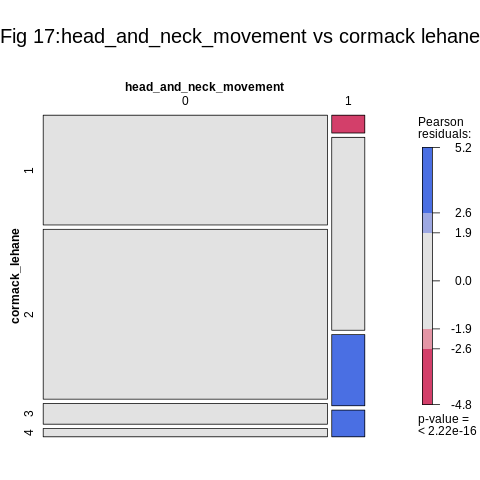

In [ ]:
%%R

# Mosaic plot of head_and_neck_movement vs cormack lehane
art <- xtabs(~head_and_neck_movement + cormack_lehane, data = df_r)

cat("Contigency table\n")
cat("==============\n")
print(art)

mosaic(art, gp = shading_max,
       split_vertical = TRUE,
       main="Fig 17:head_and_neck_movement vs cormack lehane")


Distribution of Cormack Lehane for head and neck movement = 1:


,count
cormack lehane,
2,65
3,24
4,9
1,6



Percentage distribution of Cormack Lehane for head and neck movement = 1:
cormack lehane
2    62.500000
3    23.076923
4     8.653846
1     5.769231
Name: proportion, dtype: float64


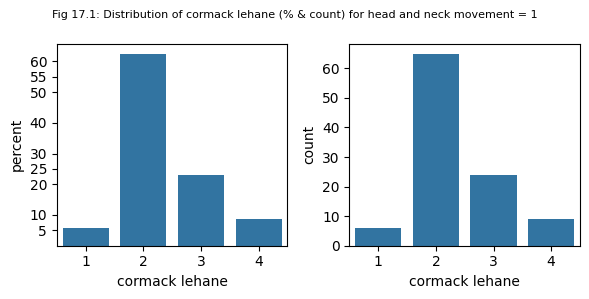

In [ ]:
# Filter data for head and neck movement of 1 and
#   then check the distribution of cormack lehane

# Filter the data for head and neck movement of 1
df_hnm1 = df[df['head and neck movement'] == 1]

# Check the distribution of 'cormack lehane' for the filtered data
cormack_lehane_distribution_hnm1 = df_hnm1['cormack lehane'].value_counts()

print("Distribution of Cormack Lehane for head and neck movement = 1:")
cormack_lehane_distribution_hnm1

print("\nPercentage distribution of Cormack Lehane for head and neck movement = 1:")
print("======================================================================")
cormack_lehane_distribution_hnm1_percent = df_hnm1['cormack lehane'].value_counts(normalize=True) * 100
print(cormack_lehane_distribution_hnm1_percent)

# Optional: Visualize the distribution for this filtered subset
fig, axs = plt.subplots(1,2, figsize=(6, 3))
g=sns.countplot(x='cormack lehane', data=df_hnm1, stat='percent', ax = axs[0])
_=g.set_yticks([5,10,20,25,30,40,50,55, 60])
_=sns.countplot(x='cormack lehane', data=df_hnm1, ax = axs[1])
_=plt.suptitle('Fig 17.1: Distribution of cormack lehane (% & count) for head and neck movement = 1', fontsize = 8)
_=plt.tight_layout()
_=plt.show()

###### **Observations-11**

>1. cormack lehane` and `head and neck movement` are not independent.       
>2. Those with head_and_neck_movement of 1 tend not to have cormack lehane of 1
>3. Those with head_and_neck_movement of 0 have no preference for any score of cormack lehane.

                      subluxation_of_mandible
head_and_neck_movement   0   1   2
                     0 761 112  18
                     1  65  31   6


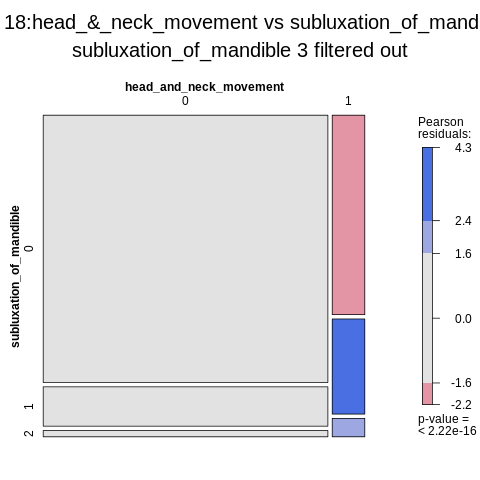

In [ ]:
%%R

# Filtering out subluxation_of_mandible of 3
temp<-df_r %>% filter(subluxation_of_mandible != 3)
temp$subluxation_of_mandible <- temp$subluxation_of_mandible[ , drop=TRUE]


#5. head_and_neck_movement vs subluxation_of_mandible
art <- xtabs(~head_and_neck_movement + subluxation_of_mandible, data = temp)

print(art)

mosaic(art,
       gp = shading_max,
       split_vertical = TRUE,
       main="Fig 18:head_&_neck_movement vs subluxation_of_mandible\nsubluxation_of_mandible 3 filtered out"
       )

###### **Observations-12**

>1. `head_and_neck_movement` and `subluxation_of_mandible` are associated.     

>2. People with `head_and_neck_movement` of 0 have no preference for any level of `subluxation_of_mandible`.  



##### edentulous vs subluxation_of_mandible

          subluxation_of_mandible
edentulous   0   1   2
         0 682 131  10
         1 144  12  14


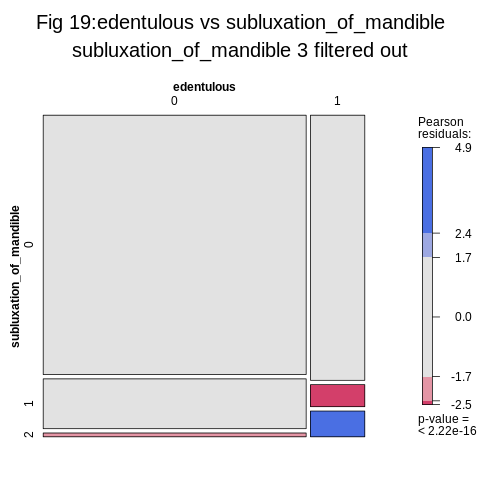

In [ ]:
%%R

# edentulous vs subluxation_of_mandible

# Filtering out subluxation_of_mandible of 3
temp<-df_r %>% filter(subluxation_of_mandible != 3)
temp$subluxation_of_mandible <- temp$subluxation_of_mandible[ , drop=TRUE]

art <- xtabs(~edentulous + subluxation_of_mandible  , data = temp)

print(art)
mosaic(art,
       gp = shading_max,
       split_vertical = TRUE,
       main="Fig 19:edentulous vs subluxation_of_mandible\nsubluxation_of_mandible 3 filtered out"
       )



In [ ]:
# Perform chisquare test to check if edentulous and subluxation of mandible are independent


# Create a contingency table of edentulous and subluxation of mandible
contingency_table = pd.crosstab(df['edentulous'], df['subluxation of mandible'])

print("Contingency Table:")
print(contingency_table)

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

# Interpret the result
alpha = 0.05
if p < alpha:
    print("\nConclusion: Reject the null hypothesis. Edentulous and subluxation of mandible are likely dependent.")
else:
    print("\nConclusion: Fail to reject the null hypothesis. Edentulous and subluxation of mandible are likely independent.")


Contingency Table:
subluxation of mandible    0    1   2  3
edentulous                              
0                        682  131  10  2
1                        144   12  14  3

Chi-square statistic: 42.4906
P-value: 0.0000
Degrees of freedom: 3
Expected frequencies:
[[682.81563126 118.21142285  19.83967936   4.13326653]
 [143.18436874  24.78857715   4.16032064   0.86673347]]

Conclusion: Reject the null hypothesis. Edentulous and subluxation of mandible are likely dependent.


###### **Observations-13**

>`edentulous` vs `subluxation_of_mandible` are not independent.

          mallampatti
edentulous   1   2   3   4
         0 228 470 113  14
         1  41  98  30   4


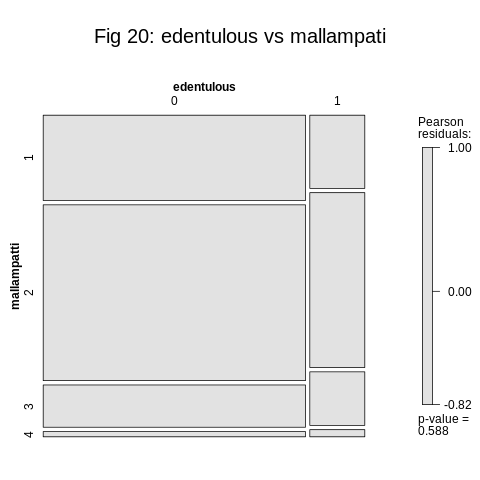

In [ ]:
%%R

# 4. Mosaic plot of mallampatti vs edentulous

art <- xtabs(~edentulous + mallampatti, data = df_r)

mosaic(art,
       gp = shading_max,
       split_vertical = TRUE,
       main="Fig 20: edentulous vs mallampati"
       )

print(art)


###### **Observations-14**

>`edentulous` and `mallampatti` are independent

##### age vs edentulous

         edentulous
age         0   1
  [20,30] 173   9
  (30,40] 189  13
  (40,50] 226  38
  (50,60] 232 112
  (60,70]   5   1


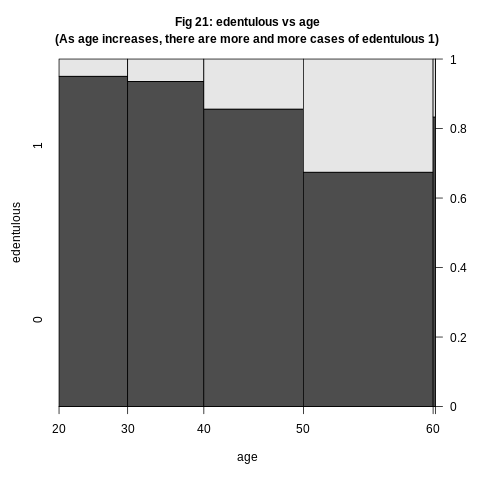

In [ ]:
%%R

# We draw spine plot to see how edenutlous is affected by age

(spine(edentulous ~ age,
       data = df_r,
       breaks = 4,
       main = "Fig 21: edentulous vs age\n(As age increases, there are more and more cases of edentulous 1)"))

Spine plots, also known as spinograms or rib charts, are a type of bar chart used to visualize data with a hierarchical structure. They are a special case of mosaic plots and can be seen as a generalization of stacked bar plots, particularly when dealing with two categorical variables. The width of each bar in a spine plot represents the proportion of the total population that falls within that category. This is where the "spine" gets its name – it represents the overall proportion of the data.



In [ ]:
# Is there a significant difference in mean age when grouped edentulous wise

# Separate the DataFrame into two groups based on 'edentulous'
# Assuming 'edentulous' has categories 0 and 1 based on the mosaic plot and df.info()
group_edentulous_0 = df[df['edentulous'] == 0]['age']
group_edentulous_1 = df[df['edentulous'] == 1]['age']

# Perform independent t-test
# Check if both groups have more than one sample to perform the t-test
if len(group_edentulous_0) > 1 and len(group_edentulous_1) > 1:
    t_stat_edentulous, p_value_edentulous = ttest_ind(group_edentulous_0, group_edentulous_1, nan_policy='omit')

    print(f"Mean age for edentulous 0: {group_edentulous_0.mean():.2f}")
    print(f"Mean age for edentulous 1: {group_edentulous_1.mean():.2f}")
    print(f"T-statistic: {t_stat_edentulous:.4f}")
    print(f"P-value: {p_value_edentulous:.4f}")

    # Interpret the result
    alpha = 0.05
    if p_value_edentulous < alpha:
        print("\nConclusion: The mean ages for edentulous 0 and edentulous 1 are significantly different.")
    else:
        print("\nConclusion: There is no significant difference in the mean ages for edentulous 0 and edentulous 1.")
else:
    print("Cannot perform t-test: One or both edentulous groups have insufficient samples.")

# Additionally, look at the mean ages directly
print("\nMean age by 'edentulous' level:")
print(df.groupby('edentulous')['age'].mean())

# And the count in each group
print("\nCounts by 'edentulous' level:")
print(df['edentulous'].value_counts())


Mean age for edentulous 0: 41.94
Mean age for edentulous 1: 50.89
T-statistic: -9.5165
P-value: 0.0000

Conclusion: The mean ages for edentulous 0 and edentulous 1 are significantly different.

Mean age by 'edentulous' level:
edentulous
0    41.938182
1    50.890173
Name: age, dtype: float64

Counts by 'edentulous' level:
edentulous
0    825
1    173
Name: count, dtype: int64


###### **Observations-15**

>Percentage of cases with `edentulous` of 1 increase with `age`. The mean ages for edentulous 0 and edentulous 1 are significantly different.

##### subluxation_of_mandible vs age

         subluxation_of_mandible
age         0   1   2   3
  [20,30] 151  31   0   0
  (30,40] 177  25   0   0
  (40,50] 219  39   4   2
  (50,60] 273  48  20   3
  (60,70]   6   0   0   0


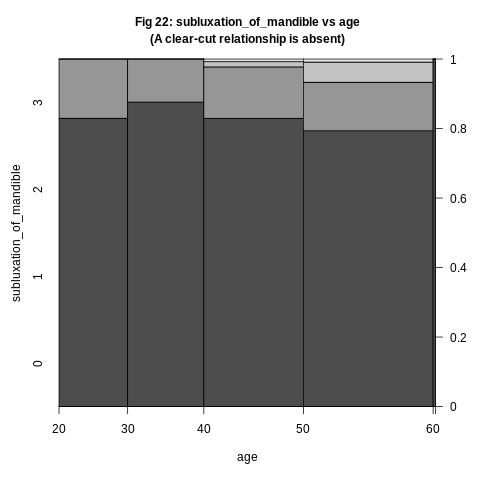

In [ ]:
%%R

# We draw spine plot to see how edenutlous is affected by age

# ("sex", "subluxation_of_mandible", "head_and_neck_movement",
#              "buck_teeth", "edentulous", "mallampatti", "mouth_opening",
#              "cormack_lehane")


(spine(subluxation_of_mandible ~ age,
       data = df_r,
       breaks = 4,
       main = "Fig 22: subluxation_of_mandible vs age\n(A clear-cut relationship is absent)"))

###### **Observations-16**

>A clear-cut or clean relationship between subluxation_of_mandible and age is not visible

##### mallampatti vs age

         mallampatti
age         1   2   3   4
  [20,30]  64 106  12   0
  (30,40]  65 110  24   3
  (40,50]  59 148  52   5
  (50,60]  80 199  55  10
  (60,70]   1   5   0   0


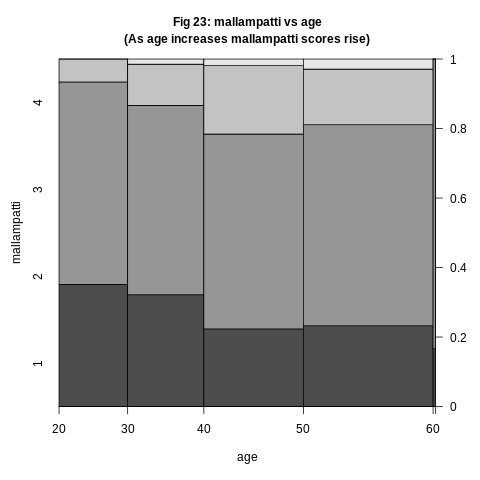

In [ ]:
%%R

# We draw spine plot to see how mallampatti is affected by age

(spine(mallampatti ~ age ,
       data = df_r,
       breaks = 4,
       main = "Fig 23: mallampatti vs age\n(As age increases mallampatti scores rise)"))

In [ ]:
# Is mean age when grouped mallampatti wise different

# Is mean age when grouped mallampatti wise different?

# Separate the DataFrame into groups based on 'mallampatti'
# Assuming 'mallampatti' has categories based on the value_counts and mosaic plots
mallampatti_groups = [df[df['mallampatti'] == level]['age'] for level in df['mallampatti'].unique()]

# Check if there are at least two groups with more than one sample each
valid_groups = [group for group in mallampatti_groups if len(group) > 1]

if len(valid_groups) >= 2:
    # Perform one-way ANOVA test to compare the means of age across different mallampatti groups
    from scipy.stats import f_oneway
    f_stat_mallampatti, p_value_mallampatti = f_oneway(*valid_groups, nan_policy='omit')

    print("Mean age by 'mallampatti' level:")
    print(df.groupby('mallampatti')['age'].mean())

    print(f"\nANOVA F-statistic: {f_stat_mallampatti:.4f}")
    print(f"ANOVA P-value: {p_value_mallampatti:.4f}")

    # Interpret the result
    alpha = 0.05
    if p_value_mallampatti < alpha:
        print("\nConclusion: The mean age is significantly different across different mallampatti levels.")
        # If ANOVA is significant, you might want to perform post-hoc tests (e.g., Tukey's HSD)
        # to see which specific pairs of groups are different.
        # Requires additional libraries like statsmodels for post-hoc tests.
        try:
            from statsmodels.stats.multicomp import pairwise_tukeyhsd
            # Reshape data for Tukey's HSD test
            tukey_data = df[['age', 'mallampatti']].dropna()
            # Perform Tukey's HSD test
            tukey_result = pairwise_tukeyhsd(endog=tukey_data['age'], groups=tukey_data['mallampatti'], alpha=alpha)
            print("\nTukey's Honestly Significant Difference (HSD) Test:")
            print(tukey_result)
        except ImportError:
            print("\nInstall statsmodels library for Tukey's HSD post-hoc test (!pip install statsmodels)")
        except ValueError as e:
             print(f"\nCould not perform Tukey's HSD test: {e}")

else:
    print("Cannot perform ANOVA: Insufficient groups or samples for comparison.")

# Visual confirmation from the spine plot (Fig 23) also suggests a relationship between mallampatti and age.

Mean age by 'mallampatti' level:
mallampatti
1    41.375465
2    43.466549
3    46.853147
4    49.111111
Name: age, dtype: float64

ANOVA F-statistic: 8.3733
ANOVA P-value: 0.0000

Conclusion: The mean age is significantly different across different mallampatti levels.

Tukey's Honestly Significant Difference (HSD) Test:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   2.0911 0.0718 -0.1213  4.3035  False
     1      3   5.4777    0.0  2.3842  8.5712   True
     1      4   7.7356 0.0321  0.4582 15.0131   True
     2      3   3.3866 0.0102  0.5899  6.1833   True
     2      4   5.6446 0.1777 -1.5117 12.8008  False
     3      4    2.258 0.8648 -5.2178  9.7338  False
----------------------------------------------------


###### **Observations-17**

>Mallampatti and age do have a relationship. mean age is significantly different across different mallampatti levels.

### Relationship between target and numeric features

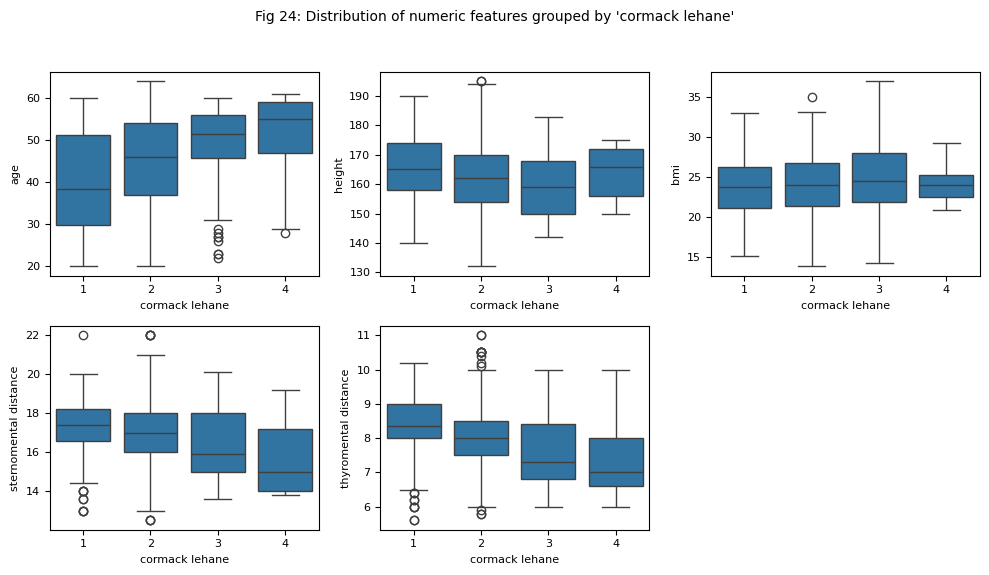

In [ ]:

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
_=fig.suptitle("Fig 24: Distribution of numeric features grouped by 'cormack lehane'", fontsize=10)

for i, col in enumerate(num_features):
    ax = axes[i // 3, i % 3]
    _=sns.boxplot(x='cormack lehane', y=col, data=df, ax=ax)
    _=ax.set_xlabel('cormack lehane', fontsize=8)
    _=ax.set_ylabel(col, fontsize=8)
    _=ax.tick_params(axis='x', labelsize=8)
    _=ax.tick_params(axis='y', labelsize=8)


# Delete the last unused axes if necessary (adjust the index based on the number of numeric features)
if len(df[num_features].columns) < 6:
    for i in range(len(df[num_features].columns), 6):
      _=axes.flatten()[i].set_visible(False)


_=plt.tight_layout(rect=[0, 0.03, 1, 0.95])
_=plt.show()


###### **Observations-18**:

>Look at each panel. There is a clear difference in medians of `age`, `height`, `bmi`, `sternomental distance` and `thyromental distance` when subsetted by different levels of cormack lehane. This is a clear indicator that all the numerical features can be good predictors for `cormack lehane`.

### Relationship between thyromental distance and sternomental distance

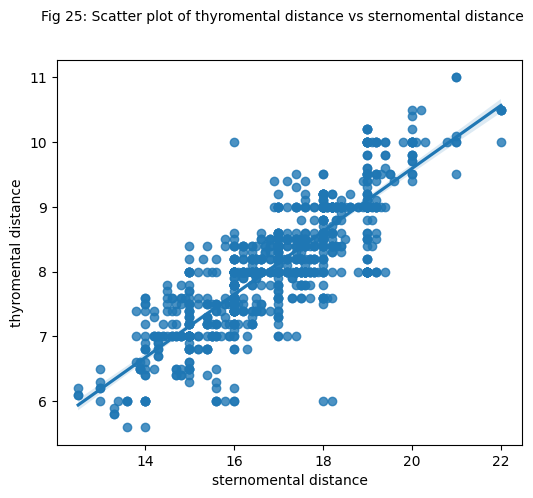

In [ ]:
# thyromental distance and sternomental distance do have a linear relationship

fig, axes = plt.subplots(1,1, figsize=(6, 5))
_=sns.regplot(data=df, x="sternomental distance",
              y="thyromental distance")
_=fig.suptitle("Fig 25: Scatter plot of thyromental distance vs sternomental distance", fontsize=10)
_=plt.show()

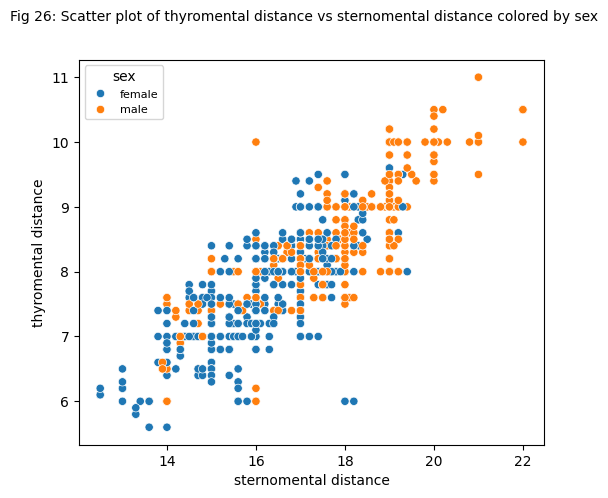

In [ ]:
# thyromental distance and sternomental distance subsetted by sex
fig, axes = plt.subplots(1,1, figsize=(6, 5))
ax=sns.scatterplot(data=df, x="sternomental distance", hue = 'sex',
              y="thyromental distance")
# Remove the default legend
_=ax.get_legend().remove()
# Add a custom legend with modified labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [label.replace('1', 'male').replace('0', 'female') for label in labels]
_=ax.legend(handles, new_labels, title="sex" , fontsize = 8)

_=fig.suptitle("Fig 26: Scatter plot of thyromental distance vs sternomental distance colored by sex", fontsize=10)
_=plt.show()

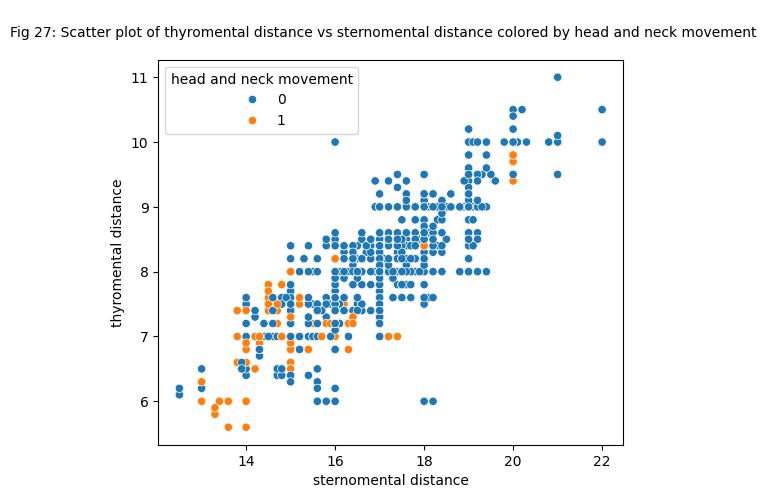

In [ ]:
# Thyromental distance and sternomental distance subsetted by head and neck movement

fig, axes = plt.subplots(1,1, figsize=(6, 5))
_=sns.scatterplot(data=df, x="sternomental distance", hue = 'head and neck movement',
              y="thyromental distance")
_=fig.suptitle("\nFig 27: Scatter plot of thyromental distance vs sternomental distance colored by head and neck movement", fontsize=10)
_=plt.show()

                     head_and_neck_movement
sternomental_distance   0   1
              [12,14]  22  23
              (14,16] 218  57
              (16,18] 444  20
              (18,20] 195   4
              (20,22]  15   0


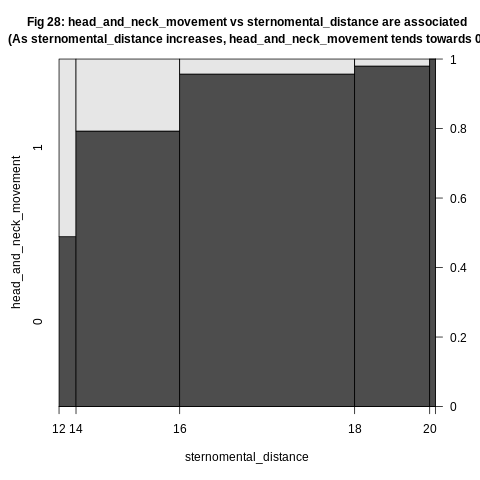

In [ ]:
%%R

# We draw spine plot to see how edenutlous is affected by age

(spine(head_and_neck_movement ~ sternomental_distance,
       data = df_r,
       breaks = 4,
       main = "Fig 28: head_and_neck_movement vs sternomental_distance are associated\n(As sternomental_distance increases, head_and_neck_movement tends towards 0)"))

###### **Observations-19**

>1. There is a linear relationship between `thyromental distance` and `sternomental distance`.
>2. There is a clear relationship between `sex` on the one hand and `thyromental distance` and `sternomental distance` on the other hand. Please see Observation-4.
>3. `head and neck movement` on the one hand and the two distances `thyromental distance` and `sternomental distance`are also related. As `sternomental_distance` increases, `head_and_neck_movement` tends towards 0.

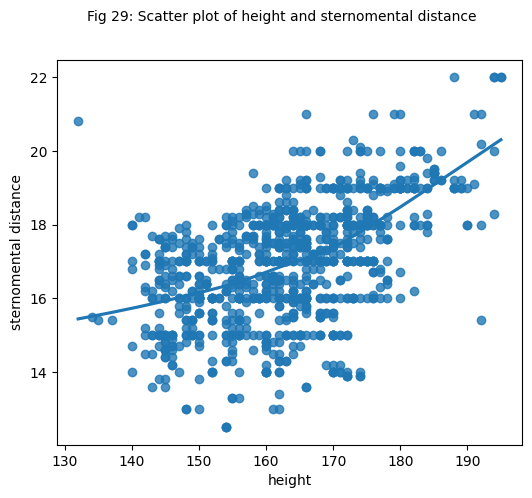

In [ ]:
# A weak relationship does exist between height and sternomental distance
fig, axes = plt.subplots(1,1, figsize=(6, 5))
_=sns.regplot(data=df, x="height",
              y="sternomental distance",
              lowess = True)
_=fig.suptitle("Fig 29: Scatter plot of height and sternomental distance", fontsize=10)
_=plt.show()

###### **Observations-20**

>There appears to be a weak relationship or a non-linear relationship between `sternomental distance` and `height`.

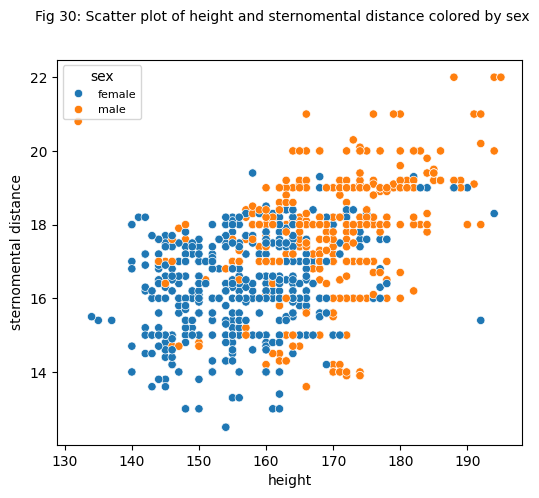

In [ ]:
# A weak relationship does exist between height and sternomental distance
fig, axes = plt.subplots(1,1, figsize=(6, 5))
ax=sns.scatterplot(data=df, x="height",
              y="sternomental distance",
              hue = 'sex')
# Remove the default legend
_=ax.get_legend().remove()
# Add a custom legend with modified labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [label.replace('1', 'male').replace('0', 'female') for label in labels]
_=ax.legend(handles, new_labels, title="sex" , fontsize = 8)
_=fig.suptitle("Fig 30: Scatter plot of height and sternomental distance colored by sex", fontsize=10)
_=plt.show()

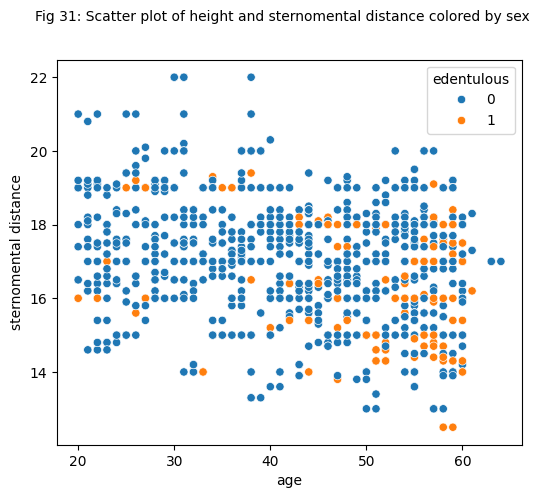

In [ ]:
# A weak relationship does exist between height and sternomental distance
fig, axes = plt.subplots(1,1, figsize=(6, 5))

data = df[df['mallampatti'] ==2]

_=sns.scatterplot(data=df, x="age",
              y="sternomental distance",
              hue = 'edentulous')

_=fig.suptitle("Fig 31: Scatter plot of height and sternomental distance colored by sex", fontsize=10)
_=plt.show()

### Correlation between numeric features

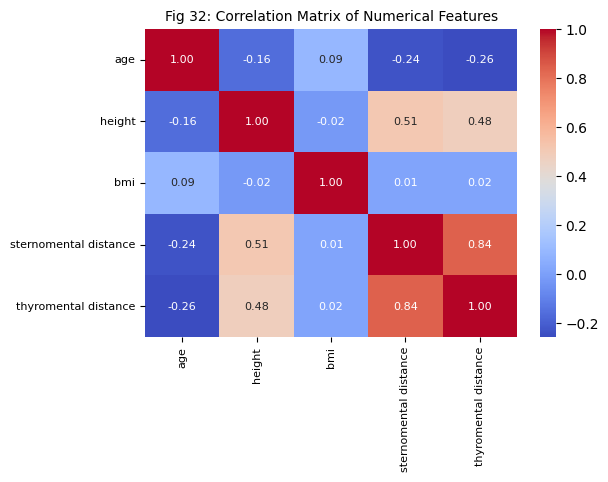

In [ ]:
# Correlation between numeric features

_=plt.figure(figsize=(6, 4))
_=sns.heatmap(df[num_features].corr(),
              annot=True,
              cmap='coolwarm',
              fmt=".2f",
              annot_kws={'size': 8}
              )
_=plt.title('Fig 32: Correlation Matrix of Numerical Features', fontsize=10)
_=plt.xticks(fontsize=8)
_=plt.yticks(fontsize=8)
_=plt.show()


###### **Observations-21**

>We have already discovered the correlated features in our earlier graphs.
>>1. `thyromental distance` and `sternomental distance` have good correlation
>>2. Weak correlation also exists between `height`, on the one hand and `thyromental distance` and `sternomental distance` on theother hand.

In [ ]:
# Is there a significant difference in mean age when grouped edentulous wise

# Separate the DataFrame into two groups based on 'edentulous'
# Assuming 'edentulous' has categories 0 and 1 based on the mosaic plot and df.info()
group_edentulous_0 = df[df['edentulous'] == 0]['age']
group_edentulous_1 = df[df['edentulous'] == 1]['age']

# Perform independent t-test
# Check if both groups have more than one sample to perform the t-test
if len(group_edentulous_0) > 1 and len(group_edentulous_1) > 1:
    t_stat_edentulous, p_value_edentulous = ttest_ind(group_edentulous_0, group_edentulous_1, nan_policy='omit')

    print(f"Mean age for edentulous 0: {group_edentulous_0.mean():.2f}")
    print(f"Mean age for edentulous 1: {group_edentulous_1.mean():.2f}")
    print(f"T-statistic: {t_stat_edentulous:.4f}")
    print(f"P-value: {p_value_edentulous:.4f}")

    # Interpret the result
    alpha = 0.05
    if p_value_edentulous < alpha:
        print("\nConclusion: The mean ages for edentulous 0 and edentulous 1 are significantly different.")
    else:
        print("\nConclusion: There is no significant difference in the mean ages for edentulous 0 and edentulous 1.")
else:
    print("Cannot perform t-test: One or both edentulous groups have insufficient samples.")

# Additionally, look at the mean ages directly
print("\nMean age by 'edentulous' level:")
print(df.groupby('edentulous')['age'].mean())

# And the count in each group
print("\nCounts by 'edentulous' level:")
print(df['edentulous'].value_counts())


Mean age for edentulous 0: 41.94
Mean age for edentulous 1: 50.89
T-statistic: -9.5165
P-value: 0.0000

Conclusion: The mean ages for edentulous 0 and edentulous 1 are significantly different.

Mean age by 'edentulous' level:
edentulous
0    41.938182
1    50.890173
Name: age, dtype: float64

Counts by 'edentulous' level:
edentulous
0    825
1    173
Name: count, dtype: int64


###### **Observations-22**

> The mean ages for edentulous 0 and edentulous 1 are significantly different.

## Predictive Analytics

### Prepare for modeling

#### Split into X and y

In [ ]:
#3.0 We keep a copy of our data
dfc = df.copy()

#3.1 Split dfc into target and predictors
y = dfc.pop('cormack lehane')
X = dfc

#### Label encode y
y ie cormack lehane now has labels 0,1,2,3

In [ ]:
# Label encode cromack lahane

le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)
print(le.transform([1,2,3,4]))
le.inverse_transform([0,1,2,3])

[1 2 3 4]
[0 1 2 3]


array([1, 2, 3, 4])

In [ ]:
# Split into train/test. We may need it at some places
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 stratify = y,
                                                 test_size = 0.20,
                                                 )

#### Create dataframes to store results
These dataframes are subsequently saved to google drive.

In [ ]:
# Our accuracy dataframe
# We will store 500 accuracy points/roc points per model
# (Repeated stratifiedKfold(cv=5), 100 times)
acc_array = pd.DataFrame()
roc_array = pd.DataFrame()
# Classification reports
classification_array=pd.DataFrame()
# logloss reports
logloss_array = pd.DataFrame()

In [ ]:
# No mallampatti score
acc_array_noMaL = pd.DataFrame()
roc_array_noMaL = pd.DataFrame()
# Classification reports
classification_array_noMaL=pd.DataFrame()
# logloss reports
logloss_array_noMaL = pd.DataFrame()

##### Data paths on gdrive

In [ ]:
# Write file paths
acc_array_path = '/gdrive/MyDrive/airways/acc_array.pkl'
roc_array_path = '/gdrive/MyDrive/airways/roc_array.pkl'
classification_array_path = '/gdrive/MyDrive/airways/classification_array.pkl'
logloss_array_path = '/gdrive/MyDrive/airways/logloss_array.pkl'
classifier_path = '/gdrive/MyDrive/airways/'

##### Read back any already saved data
Read earlier saved results from gdrive.

In [ ]:
if os.path.exists(acc_array_path ):
    acc_array = pd.read_pickle(acc_array_path)

if os.path.exists(roc_array_path):
    roc_array = pd.read_pickle(roc_array_path)

if os.path.exists(classification_array_path):
    classification_array = pd.read_pickle(classification_array_path)

if os.path.exists(logloss_array_path):
    logloss_array = pd.read_pickle(logloss_array_path)

In [ ]:
## Check if data retrieved
print("Accuracy")
acc_array.head(2)
print("AUC")
roc_array.head(2)
print("Classification metrics")
classification_array.head(2)
print("logloss")
logloss_array.head(2)

### RandomForest Classifier

#### Repeated StartifiedKFold

In [ ]:
%%time

# RF classifier.
clf =  RandomForestClassifier(criterion='entropy',  # split criterion
                              n_estimators=400,      # Number of decsion trees
                              warm_start=False
                              )

n = 100
# Store (cormack lehane) classwise classification-report
# over all n-repeated 5-fold n_splits:
total_class0 = []  # [class0] * n
total_class1 = []  # [[['precision', 'recall', 'f1-score', 'support'] * n_splits ] *n]
total_class2 = []  # [class2] * n
total_class3 = []  # [class3] * n
# To store, class-wise roc-data, for n attempts
all_roc_auc = []
# To store accuracy data for n attempts
total_acc_list = []
# To store logloss data for n attempts
total_ll_list = []
count = 1

print("==******************************************" )
print(f"Total number of folds would be: {n * 5}" )
print("==******************************************\n\n" )

# We take 5-random folds n times
for i in range(n):
  start = time.time()
  # To store accuracy data averaged over all classes
  list_accu_stratified = []
  # To store logloss
  list_ll_stratified = []
  # Class-wise roc-data for each of the classes for five folds
  list_roc_auc = []
  # Classwise classification report per cross-validation
  class0 = []  # class0: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class1 = []  # class1: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class2 = []  # class2: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class3 = []  # class3: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]

  # Get Stratified K-Fold cross-validator object
  skf = StratifiedKFold(
                        n_splits=5,
                        shuffle=True
                        )

  # Iterate 5-times ie once per split/fold
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]  # y is label encoded
      print("=======")
      print("fold:", count ) ; count = count +1
      if (i < 1):
        print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Use X_train, X_test, y_train, y_test to train/evaluate model in each fold
      clf.fit(X_train, y_train)

      # 1. Get accuracy in this particular split (but averaged over all classes)
      acc = clf.score(X_test, y_test)
      print("Accuracy for this fold/split averaged over all the classes:", acc)
      list_accu_stratified.append(acc)

      # 2. Get class-wise AUC scores:
      # ovr==>One-vs-rest auc
      auc_class = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr', # Ref: https://stackoverflow.com/a/66022487
                          average = None)

      print("Class-wise AUC for this fold/split:", auc_class)
      list_roc_auc.append(auc_class)

      # 3. Classification report: precision/f1/recall/support
      sk = classification_report(y_test,
                                 clf.predict(X_test),
                                 output_dict = True  # dict format and not tabular format
                                 )
      # sk['0'].values(): ['precision', 'recall', 'f1-score', 'support']
      #                   for class-0 of cormack lehane
      class0.append(list(sk['0'].values()))
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

      # 4.0 log_loss
      prob = clf.predict_proba(X_test)
      ll = log_loss(y_test, prob)
      print("logloss for this fold/split:", ll)
      list_ll_stratified.append(ll)

  total_acc_list.append(list_accu_stratified)
  total_ll_list.append(list_ll_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)
  print(f"Mean accuracy over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_acc_list).flatten())}")
  print(f"Mean logloss over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_ll_list).flatten())}")
  end = time.time()
  print(f"Time taken for 5-folds {(end-start)/60} min")

# The last fitted classifier object
randomForest_classifier = clf

In [ ]:
# Just check shapes of our metrics collectors
# n_splits: 5
# Repeated n_splits:100
# No of classes: 4
# No of classification scores: 4 (precision/recall/f1/support)

# 1. Classification reports
np.array(class0).shape                 # (5x4)       [For everyone of n_splits, one report]
np.array(total_class0).shape           # (100, 5, 4)
# 2. AUC
np.array(list_roc_auc).shape           # (5X4)       [For everyone of n_splits, AUC over all 4 classes]
np.array(all_roc_auc).shape            # (100, 5, 4)
# 3. Accuracy
np.array(list_accu_stratified).shape   # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_acc_list).shape         # (100,5)
# 4. logloss
np.array(list_ll_stratified).shape     # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_ll_list).shape          # (100,5)

#### AUC scores (randomforest modeling)

>AUC, short for Area Under the Curve, is a metric used in machine learning to evaluate the performance of binary classification models. It essentially measures the ability of a model to distinguish between positive and negative classes. A higher AUC value indicates a better-performing model, with a perfect model having an AUC of 1.0 and a random model having an AUC of 0.5. AUC is calculated from the Receiver Operating Characteristic (ROC) curve, which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classification thresholds.       

>>An AUC of 1.0 represents perfect discrimination between classes, meaning the model can correctly classify all positive and negative instances.       
>>An AUC of 0.5 indicates the model is performing no better than random guessing, and it cannot distinguish between classes.       

>>An AUC between 0.5 and 1.0 indicates the model is performing better than random guessing, with a higher AUC suggesting a stronger ability to distinguish between classes.        




About OvR AUC:       

>One-vs-rest (OvR) AUC refers to a method for evaluating the performance of a multiclass classification model by treating each class as a binary classification problem against all other classes. This approach computes the Area Under the Curve (AUC) for each class individually, effectively transforming the multiclass problem into multiple binary classification problems. One class is treated as the "positive" class and all other classes as the "negative" class.


In [ ]:
# AUC data compilation (randomforest)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("RandomForest--Class-wise mean of AUCs:    " ,all_roc_auc_array.reshape(500,4).mean(axis=0))
# Class-wise std dev of AUCs
print("RandomForest--Class-wise std devs of AUCs:" ,all_roc_auc_array.reshape(500,4).std(axis=0))

(100, 5, 4)

RandomForest--Class-wise mean of AUCs:     [0.96094003 0.95179423 0.96349827 0.98156686]
RandomForest--Class-wise std devs of AUCs: [0.01572159 0.01615472 0.0369765  0.04846709]


#### AUC distribution plot (randomforest)

In [ ]:
# Classwise AUCs in 500 iterations (randoforest)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['randomforest'] = pd.Series(res)

In [ ]:
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['randomforest'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']

print("              Class-wise AUCs")
classwise_roc.head()  # (500, 4)

              Class-wise AUCs


,class1,class2,class3,class4
0,0.938462,0.919085,0.959918,0.970392
1,0.941521,0.939428,0.996143,1.000000
2,0.965584,0.955259,0.971713,0.947446
3,0.971125,0.952856,0.997738,0.797927
4,0.952354,0.943387,0.922592,0.996546


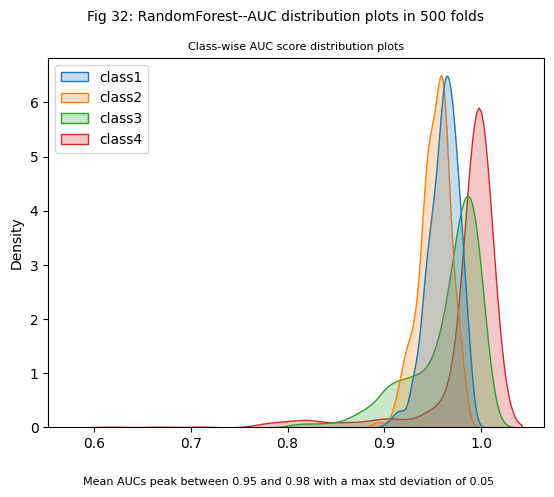

In [ ]:
# How are AUC distributed over 500 folds? (randomforest)
_=sns.kdeplot(classwise_roc, fill=True)
_=plt.suptitle("Fig 32: RandomForest--AUC distribution plots in 500 folds ", ha="center", fontsize=10)
_=plt.title("Class-wise AUC score distribution plots", ha="center", fontsize=8)
min = np.round(np.min(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
max = np.round(np.max(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
maxsd = np.round(np.max(all_roc_auc_array.reshape(500,4).std(axis=0)),2)
_=plt.figtext(0.5, -0.01, f"Mean AUCs peak between {min} and {max} with a max std deviation of {maxsd}",
              ha="center",
              fontsize=8)
_=plt.show()

#### Accuracy distribution (randomforest modeling)

In [ ]:
print("===randomforest=====")
acc_array['randomforest'] = np.array(total_acc_list).flatten()

===randomforest=====


In [ ]:
print("Overall Accuracy               :", np.mean(acc_array['randomforest']))
print("Median Accuracy                :", np.median(acc_array['randomforest']))
print("Std deviation of accuracy      :", np.std(acc_array['randomforest']))
print("Class-wise avg AUC score       :", all_roc_auc_array.reshape(500,4).mean(axis=0))
print("Class-wise avg std dev of AUCs :", all_roc_auc_array.reshape(500,4).std(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

Overall Accuracy               : 0.881825527638191
Median Accuracy                : 0.8844221105527639
Std deviation of accuracy      : 0.02279164790447726
Class-wise avg AUC score       : [0.96094003 0.95179423 0.96349827 0.98156686]
Class-wise avg std dev of AUCs : [0.01572159 0.01615472 0.0369765  0.04846709]
(for classes 1,2,3,4 respectively)


#### Distribution plot for accuracy (randomforest)

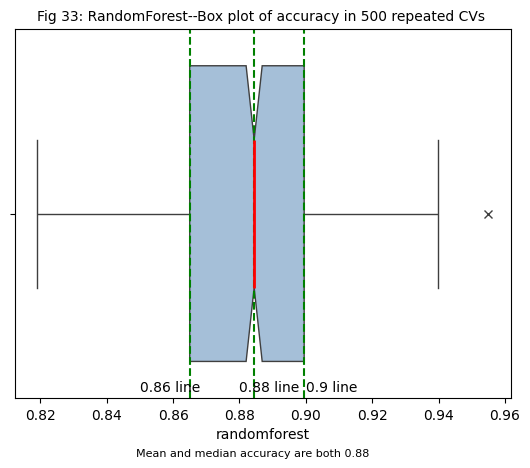

In [ ]:
# Accuracy box plot. How accuracy varies over CV trials (randomforest)
_=plt.title("Fig 33: RandomForest--Box plot of accuracy in 500 repeated CVs ",
            ha="center",
            fontsize=10)
ax=sns.boxplot(
            data=acc_array, x="randomforest",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )

pts = np.quantile(acc_array['randomforest'], [0.25,0.5,0.75])

_=ax.axvline(x=pts[0], color='g', linestyle='--')
_=ax.axvline(x=pts[1], color='g', linestyle='--')
_=ax.axvline(x=pts[2], color='g', linestyle='--')  # 75% obs above this line

_=ax.text(0.85,0.48, f"{np.round(pts[0],2)} line")
_=ax.text(0.88,0.48, f"{np.round(pts[1],2)} line")
_=ax.text(0.90,0.48, f"{np.round(pts[2],2)} line")

_=plt.figtext(0.5, -0.01, f"Mean and median accuracy are both {np.round(pts[1],2)} ",
              ha="center",
              fontsize=8)
_=plt.show()

#### logloss (randomForest)

In [ ]:
print("===randomforest=====")
logloss_array['randomforest'] = np.array(total_ll_list).flatten()

===randomforest=====


In [ ]:
print("Overall mean logloss          :", np.mean(logloss_array['randomforest']))
print("Median logloss                :", np.median(logloss_array['randomforest']))
print("Std deviation of logloss      :", np.std(logloss_array['randomforest']))
print("========")

Overall mean logloss          : 0.4177799004873771
Median logloss                : 0.4032912482081993
Std deviation of logloss      : 0.0699972224247603


#### precision/recall/f1 scores (randomforest modeling)

In [ ]:
# Classification scores (randomforest)
classification_scores = np.array(total_class0)
res =  [x for sublist in classification_scores for x in sublist]
classification_array['randomforest'] = res

In [ ]:
# 'Explode' the list into columns
metricswise_classification_scores = classification_array['randomforest'].apply(pd.Series)

# Rename the columns
metricswise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
print("======")
print(f"Mean classification scores\n\n{metricswise_classification_scores.mean()}")
print("======")
print("")
print(f"Std Dev of classification scores\n\n{metricswise_classification_scores.std()}")
print("======")


Mean classification scores

precision     0.898125
recall        0.845660
f1-score      0.869875
support      64.800000
dtype: float64

Std Dev of classification scores

precision    0.040836
recall       0.050491
f1-score     0.033239
support      0.400401
dtype: float64


#### precision/recall/f1 scores distribution plots

>The **F1 score** is a metric that evaluates a model's accuracy by combining precision and recall. It's calculated as the harmonic mean of these two values, providing a balanced view of a model's ability to correctly identify positive instances (precision) and avoid missing any positive instances (recall).

>>**Precision**: Measures the proportion of true positive predictions out of all positive predictions made by the model. It focuses on how many of the model's predictions were correct.

>>**Recall**: Measures the proportion of true positive predictions out of all actual positive instances in the dataset. It focuses on how well the model captures all the relevant positive instances.

>>**Harmonic Mean**: The F1 score uses the harmonic mean, which gives more weight to lower values of precision or recall. This means that if either precision or recall is very low, the F1 score will also be low, even if the other metric is high.

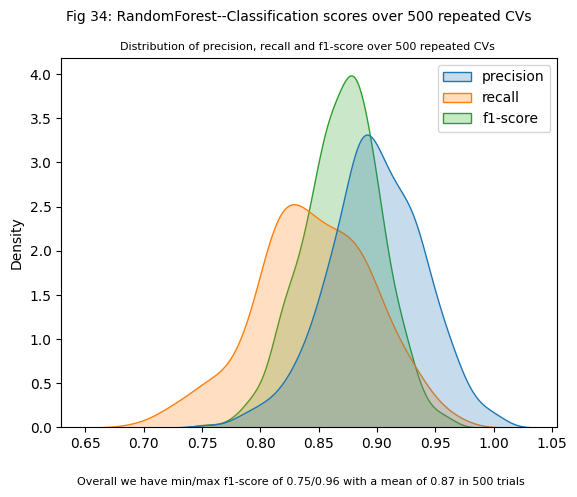

In [ ]:
# Classification score distribution plots--500 in 500 repeated CVs (randoforest)
_=sns.kdeplot(metricswise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle("Fig 34: RandomForest--Classification scores over 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Distribution of precision, recall and f1-score over 500 repeated CVs ", ha="center", fontsize=8)
f1_min = np.round(metricswise_classification_scores['f1-score'].min(),2)
f1_max = np.round(metricswise_classification_scores['f1-score'].max(),2)
f1_mean= np.round(metricswise_classification_scores['f1-score'].mean(),2)
_=plt.figtext(0.5, -0.01, f"Overall we have min/max f1-score of {f1_min}/{f1_max} with a mean of {f1_mean} in 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

#### Save to gdrive

In [ ]:
acc_array.to_pickle(acc_array_path)
roc_array.to_pickle(roc_array_path)
classification_array.to_pickle(classification_array_path)
logloss_array.to_pickle(logloss_array_path)

# Save the classifier
with open(classifier_path+ "randomForest_classifier.pkl", "wb") as f:
    dump(randomForest_classifier, f, protocol=5)


##### Read back

In [ ]:
if os.path.exists(acc_array_path ):
    acc_array = pd.read_pickle(acc_array_path)

if os.path.exists(roc_array_path):
    roc_array = pd.read_pickle(roc_array_path)

if os.path.exists(classification_array_path):
    classification_array = pd.read_pickle(classification_array_path)

if os.path.exists(logloss_array_path):
    logloss_array = pd.read_pickle(logloss_array_path)

# Reload randomForest_classifier
with open(classifier_path+ "randomForest_classifier.pkl", "rb") as f:
    randomForest_classifier = load(f)

##### Check

In [ ]:
## Check if data retrieved
print("Accuracy")
acc_array.head(2)
print("AUC")
roc_array.head(2)
print("Classification metrics")
classification_array.head(2)
print("logloss")
logloss_array.head(2)
print("RF Classifier")
randomForest_classifier

Accuracy


,randomforest,histclassifier,extratrees,xgbclf
0,0.840,0.855,0.930,0.925
1,0.865,0.900,0.895,0.850


AUC


,randomforest,histclassifier,extratrees,xgbclf
0,"[0.9384615384615385, 0.9190848214285715, 0.959...","[0.9187464387464388, 0.9074675324675325, 0.903...","[0.9616524216524217, 0.962104301948052, 0.9962...","[0.9785754985754985, 0.968648538961039, 0.9983..."
1,"[0.9415211397058824, 0.9394277597402597, 0.996...","[0.9698988970588235, 0.9694602272727273, 0.981...","[0.9794921875, 0.9686485389610389, 0.994214079...","[0.9526654411764706, 0.9248173701298702, 0.900..."


Classification metrics


,randomforest,histclassifier,extratrees,xgbclf
0,"[0.8947368421052632, 0.7846153846153846, 0.836...","[0.875, 0.7538461538461538, 0.8099173553719008...","[0.9230769230769231, 0.9230769230769231, 0.923...","[0.9516129032258065, 0.9076923076923077, 0.929..."
1,"[0.8548387096774194, 0.828125, 0.8412698412698...","[0.875, 0.875, 0.875, 64.0]","[0.8769230769230769, 0.890625, 0.8837209302325...","[0.8983050847457628, 0.828125, 0.8617886178861..."


logloss


,randomforest,histclassifier,extratrees,xgbclf
0,0.464156,1.004075,0.581464,0.252733
1,0.416657,0.444468,0.427307,0.516338


RF Classifier


RandomForestClassifier(criterion='entropy', n_estimators=400)

### HistGradientBoostingClassifier

#### Hyperparameter search

> We use `RandomizedSearchCV` class of sklearn for optimizing hyperparameters. Randomized Search CV is a hyperparameter tuning technique that randomly samples a subset of combinations from a predefined search space of hyperparameters, and then evaluates the model's performance on each combination using cross-validation. It's a more efficient approach than `GridSearchCV`, especially when dealing with large hyperparameter spaces, as it doesn't exhaustively evaluate every combination.

In [ ]:
%%time

# Hyperparameter search Takes 20minutes

hist_classifier = HistGradientBoostingClassifier(
                                                 categorical_features = cat_features,
                                                 loss = 'log_loss',
                                                 warm_start=False
                                                 )


param_grid = {
              "learning_rate": [0.01, 0.05, 0.1, 0.15],
              "min_samples_leaf": [15,20, 22,25,30],
              "max_leaf_nodes": [7, 10, 15, 20,25,30,35, 40,45],
              "l2_regularization": loguniform(1e-4, 1e-2),
              "max_features" : [0.5,0.6,0.7,0.8,0.9,1],
              "max_iter"     : [150,200,250,300,350]
             }

# Takes time
model_random_search = RandomizedSearchCV(hist_classifier,
                                         param_distributions=param_grid,
                                         n_jobs=-1,
                                         n_iter = 200, # 200 points search. Takes time
                                         cv=5          # For each point, 5-fold evaluation
                                       )


model_random_search.fit(X_train, y_train)
hist_bst_param= model_random_search.best_params_
hist_bst_param


CPU times: user 11.9 s, sys: 1.93 s, total: 13.8 s
Wall time: 18min 23s


{'l2_regularization': np.float64(0.0008765786227423513),
 'learning_rate': 0.1,
 'max_features': 0.8,
 'max_iter': 300,
 'max_leaf_nodes': 45,
 'min_samples_leaf': 15}

#### Repeated StartifiedKFold

In [ ]:
# We now use the hyperparamer values:

l2_regularization = 0.0008765786227423513
learning_rate = 0.1
max_features = 0.8
max_iter = 300
max_leaf_nodes = 45
min_samples_leaf = 15

In [ ]:
%%time



clf = HistGradientBoostingClassifier(max_iter= max_iter,
                                     max_leaf_nodes= max_leaf_nodes,
                                     min_samples_leaf = min_samples_leaf,
                                     l2_regularization = l2_regularization,
                                     categorical_features = cat_features,
                                     learning_rate = learning_rate,
                                      max_features = max_features,
                                      #class_weight = 'balanced'
                                      )


n = 100
# Store (cormack lehane) classwise classification-report
# over all n-repeated 5-fold n_splits:
total_class0 = []  # [class0] * n
total_class1 = []  # [[['precision', 'recall', 'f1-score', 'support'] * n_splits ] *n]
total_class2 = []  # [class2] * n
total_class3 = []  # [class3] * n
# To store, class-wise roc-data, for n attempts
all_roc_auc = []
# To store accuracy data for n attempts
total_acc_list = []
# To store logloss data for n attempts
total_ll_list = []
count = 1

print("==******************************************" )
print(f"Total number of folds would be: {n * 5}" )
print("==******************************************\n\n" )

# We take 5-random folds n times
for i in range(n):
  start = time.time()
  # To store accuracy data averaged over all classes
  list_accu_stratified = []
  # To store logloss
  list_ll_stratified = []
  # Class-wise roc-data for each of the classes for five folds
  list_roc_auc = []
  # Classwise classification report per cross-validation
  class0 = []  # class0: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class1 = []  # class1: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class2 = []  # class2: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class3 = []  # class3: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]

  # Get Stratified K-Fold cross-validator object
  skf = StratifiedKFold(
                        n_splits=5,
                        shuffle=True
                        )

  # Iterate 5-times ie once per split/fold
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]  # y is label encoded
      print("=======")
      print("fold:", count ) ; count = count +1
      if (i < 1):
        print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Use X_train, X_test, y_train, y_test to train/evaluate model in each fold
      clf.fit(X_train, y_train)

      # 1. Get accuracy in this particular split (but averaged over all classes)
      acc = clf.score(X_test, y_test)
      print("Accuracy for this fold/split averaged over all the classes:", acc)
      list_accu_stratified.append(acc)

      # 2. Get class-wise AUC scores:
      # ovr==>One-vs-rest auc
      auc_class = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr', # Ref: https://stackoverflow.com/a/66022487
                          average = None)

      print("Class-wise AUC for this fold/split:", auc_class)
      list_roc_auc.append(auc_class)

      # 3. Classification report: precision/f1/recall/support
      sk = classification_report(y_test,
                                 clf.predict(X_test),
                                 output_dict = True  # dict format and not tabular format
                                 )
      # sk['0'].values(): ['precision', 'recall', 'f1-score', 'support']
      #                   for class-0 of cormack lehane
      class0.append(list(sk['0'].values()))
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

      # 4.0 log_loss
      prob = clf.predict_proba(X_test)
      ll = log_loss(y_test, prob)
      print("logloss for this fold/split:", ll)
      list_ll_stratified.append(ll)

  total_acc_list.append(list_accu_stratified)
  total_ll_list.append(list_ll_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)
  print(f"Mean accuracy over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_acc_list).flatten())}")
  print(f"Mean logloss over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_ll_list).flatten())}")
  end = time.time()
  print(f"Time taken for 5-folds {(end-start)/60} min")

hist_classifier = clf


In [ ]:
# Just check shapes of our metrics collectors
# n_splits: 5
# Repeated n_splits:100
# No of classes: 4
# No of classification scores: 4 (precision/recall/f1/support)

# 1. Classification reports
np.array(class0).shape                 # (5x4)       [For everyone of n_splits, one report]
np.array(total_class0).shape           # (100, 5, 4)
# 2. AUC
np.array(list_roc_auc).shape           # (5X4)       [For everyone of n_splits, AUC over all 4 classes]
np.array(all_roc_auc).shape            # (100, 5, 4)
# 3. Accuracy
np.array(list_accu_stratified).shape   # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_acc_list).shape         # (100,5)
# 4. logloss
np.array(list_ll_stratified).shape     # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_ll_list).shape          # (100,5)

(5, 4)

(100, 5, 4)

(5, 4)

(100, 5, 4)

(5,)

(100, 5)

(5,)

(100, 5)

#### AUC scores (histclassifier modeling)

In [ ]:
# AUC data compilation (histclassifier)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("HistClassifier--Class-wise mean of AUCs    :" ,all_roc_auc_array.reshape(500,4).mean(axis=0))
# Class-wise std dev of AUCs
print("HistClassifier--Class-wise std devs of AUCs:" ,all_roc_auc_array.reshape(500,4).std(axis=0))


(100, 5, 4)

HistClassifier--Class-wise mean of AUCs    : [0.95521074 0.94576784 0.94780116 0.97561732]
HistClassifier--Class-wise std devs of AUCs: [0.01862485 0.0187527  0.04709275 0.06312508]


#### AUC distribution plot (HistClassifier)

In [ ]:
# Classwise AUCs in 500 iterations (histclassifier)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['histclassifier'] = res

In [ ]:
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['histclassifier'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
print("              Class-wise AUCs")
classwise_roc.head()

              Class-wise AUCs


,class1,class2,class3,class4
0,0.918746,0.907468,0.903533,0.998520
1,0.969899,0.969460,0.981035,1.000000
2,0.970712,0.965786,0.992928,1.000000
3,0.954879,0.949017,0.925663,0.991364
4,0.969116,0.967649,0.986425,0.996546


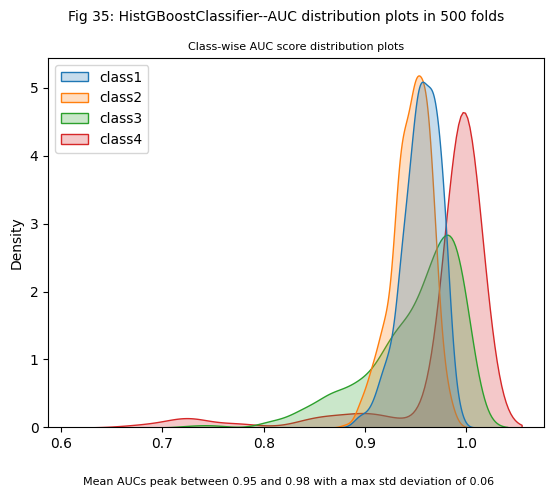

In [ ]:
# AUC distribution plots--500 folds (histclassifier)
_=sns.kdeplot(classwise_roc, fill=True)
_=plt.suptitle("Fig 35: HistGBoostClassifier--AUC distribution plots in 500 folds ", ha="center", fontsize=10)
_=plt.title("Class-wise AUC score distribution plots", ha="center", fontsize=8)
min = np.round(np.min(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
max = np.round(np.max(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
maxsd = np.round(np.max(all_roc_auc_array.reshape(500,4).std(axis=0)),2)
_=plt.figtext(0.5, -0.01, f"Mean AUCs peak between {min} and {max} with a max std deviation of {maxsd}",
              ha="center",
              fontsize=8)
_=plt.show()

#### Accuracy scores (histclassifier)


In [ ]:
# Mean accuracy scores over CV trials (extratrees)
print("===HistClassifier=====")
acc_array['histclassifier'] = np.array(total_acc_list).flatten()

===HistClassifier=====


In [ ]:
print("Mean Accuracy                  :", np.mean(acc_array['histclassifier']))
print("Median Accuracy                :", np.median(acc_array['histclassifier']))
print("Std deviation of accuracy      :", np.std(acc_array['histclassifier']))
print("Class-wise avg AUC score       :", all_roc_auc_array.reshape(500,4).mean(axis=0))
print("Class-wise avg std dev of AUCs :", all_roc_auc_array.reshape(500,4).std(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

Mean Accuracy                  : 0.8880782914572865
Median Accuracy                : 0.8894472361809045
Std deviation of accuracy      : 0.02297868034945126
Class-wise avg AUC score       : [0.95521074 0.94576784 0.94780116 0.97561732]
Class-wise avg std dev of AUCs : [0.01862485 0.0187527  0.04709275 0.06312508]
(for classes 1,2,3,4 respectively)


#### Distribution plot for accuracy (HistClassifier)

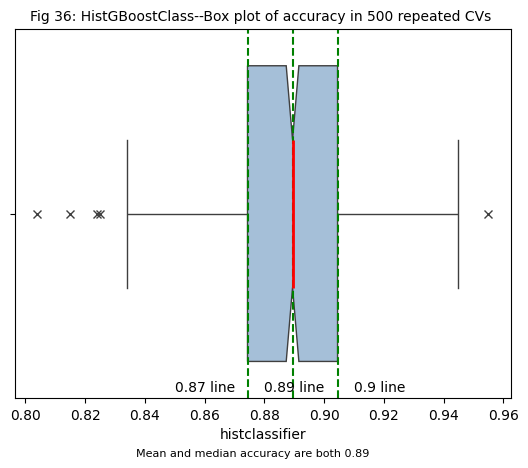

In [ ]:
# Accuracy box plot. How accuracy varies over CV trials (randomforest)
_=plt.title("Fig 36: HistGBoostClass--Box plot of accuracy in 500 repeated CVs ",
            ha="center",
            fontsize=10)
ax=sns.boxplot(
            data=acc_array, x="histclassifier",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )

pts = np.quantile(acc_array['histclassifier'], [0.25,0.5,0.75])

_=ax.axvline(x=pts[0], color='g', linestyle='--')
_=ax.axvline(x=pts[1], color='g', linestyle='--')
_=ax.axvline(x=pts[2], color='g', linestyle='--')  # 75% obs above this line

_=ax.text(0.85,0.48, f"{np.round(pts[0],2)} line")
_=ax.text(0.88,0.48, f"{np.round(pts[1],2)} line")
_=ax.text(0.91,0.48, f"{np.round(pts[2],2)} line")

_=plt.figtext(0.5, -0.01, f"Mean and median accuracy are both {np.round(pts[1],2)} ",
              ha="center",
              fontsize=8)
_=plt.show()

#### logloss (HistGradientBoostingClassifier)

In [ ]:
print("===histclassifier=====")
logloss_array['histclassifier'] = np.array(total_ll_list).flatten()

===histclassifier=====


In [ ]:
print("Overall mean logloss          :", np.mean(logloss_array['histclassifier']))
print("Median logloss                :", np.median(logloss_array['histclassifier']))
print("Std deviation of logloss      :", np.std(logloss_array['histclassifier']))
print("========")

Overall mean logloss          : 0.67338047811251
Median logloss                : 0.6576391664005646
Std deviation of logloss      : 0.18731680348916885


#### precision/recall/f1 scores (HistClassifier modeling)

In [ ]:
# Classification scores (extratrees)
classification_scores = np.array(total_class0)

# Unlist the list
res =  [x for sublist in classification_scores for x in sublist]

classification_array['histclassifier'] = res

In [ ]:
# 'Explode' the list into columns
metricswise_classification_scores = classification_array['histclassifier'].apply(pd.Series)

# Rename the columns
metricswise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
print("======")
print(f"Mean classification scores\n\n{metricswise_classification_scores.mean()}")
print("======")
print("")
print(f"Std Dev of classification scores\n\n{metricswise_classification_scores.std()}")
print("======")


Mean classification scores

precision     0.878844
recall        0.859971
f1-score      0.868162
support      64.800000
dtype: float64

Std Dev of classification scores

precision    0.042752
recall       0.047824
f1-score     0.033077
support      0.400401
dtype: float64


#### precision/recall/f1 scores distribution plots (histclassifier)

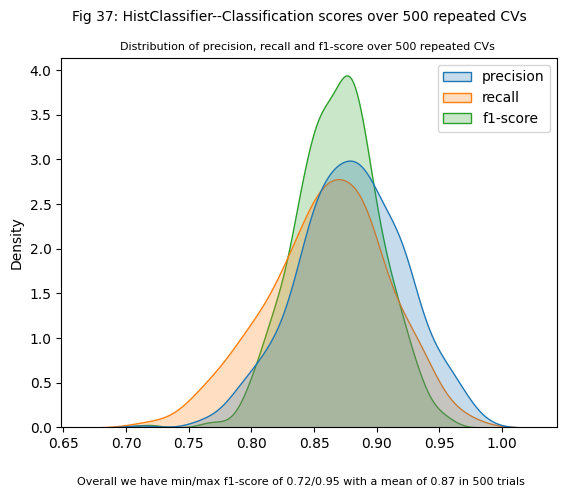

In [ ]:
# Classification score distribution plots--500 in 500 repeated CVs (randoforest)
_=sns.kdeplot(metricswise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle("Fig 37: HistClassifier--Classification scores over 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Distribution of precision, recall and f1-score over 500 repeated CVs ", ha="center", fontsize=8)
f1_min = np.round(metricswise_classification_scores['f1-score'].min(),2)
f1_max = np.round(metricswise_classification_scores['f1-score'].max(),2)
f1_mean= np.round(metricswise_classification_scores['f1-score'].mean(),2)
_=plt.figtext(0.5, -0.01, f"Overall we have min/max f1-score of {f1_min}/{f1_max} with a mean of {f1_mean} in 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

#### Save to gdrive

In [ ]:
acc_array.to_pickle(acc_array_path)
roc_array.to_pickle(roc_array_path)
classification_array.to_pickle(classification_array_path)
logloss_array.to_pickle(logloss_array_path)

# Save the classifier
with open(classifier_path+ "hist_classifier.pkl", "wb") as f:
    dump(hist_classifier, f, protocol=5)

##### Read back

In [ ]:
if os.path.exists(acc_array_path ):
    acc_array = pd.read_pickle(acc_array_path)

if os.path.exists(roc_array_path):
    roc_array = pd.read_pickle(roc_array_path)

if os.path.exists(classification_array_path):
    classification_array = pd.read_pickle(classification_array_path)

if os.path.exists(logloss_array_path):
    logloss_array = pd.read_pickle(logloss_array_path)

 # Reload hist_classifier
with open(classifier_path+ "hist_classifier.pkl", "rb") as f:
    hist_classifier = load(f)

##### Check

In [ ]:
## Check if data retrieved
print("Accuracy")
acc_array.head(2)
print("AUC")
roc_array.head(2)
print("Classification metrics")
classification_array.head(2)
print("logloss")
logloss_array.head(2)
print("hist Classifier")
hist_classifier

Accuracy


,randomforest,histclassifier,extratrees,xgbclf
0,0.880,0.855,0.91,0.895
1,0.865,0.900,0.91,0.855


AUC


,randomforest,histclassifier,extratrees,xgbclf
0,"[0.9594871794871794, 0.9632203733766234, 0.991...","[0.9187464387464388, 0.9074675324675325, 0.903...","[0.9654700854700855, 0.9605316558441558, 0.988...","[0.9496296296296297, 0.9437905844155844, 0.948..."
1,"[0.9775965073529412, 0.9710328733766234, 0.990...","[0.9698988970588235, 0.9694602272727273, 0.981...","[0.9676011029411765, 0.9577414772727272, 0.995...","[0.9379595588235293, 0.9212662337662336, 0.974..."


Classification metrics


,randomforest,histclassifier,extratrees,xgbclf
0,"[0.8888888888888888, 0.8615384615384616, 0.875...","[0.875, 0.7538461538461538, 0.8099173553719008...","[0.8939393939393939, 0.9076923076923077, 0.900...","[0.8870967741935484, 0.8461538461538461, 0.866..."
1,"[0.8412698412698413, 0.828125, 0.8346456692913...","[0.875, 0.875, 0.875, 64.0]","[0.8428571428571429, 0.921875, 0.8805970149253...","[0.8115942028985508, 0.875, 0.8421052631578947..."


logloss


,randomforest,histclassifier,extratrees,xgbclf
0,0.384165,1.004075,0.459493,0.346389
1,0.367272,0.444468,0.622944,0.393817


hist Classifier
HistGradientBoostingClassifier(categorical_features=['sex', 'buck teeth',
                                                     'edentulous',
                                                     'mallampatti',
                                                     'mouth opening',
                                                     'subluxation of mandible',
                                                     'head and neck movement'],
                               l2_regularization=0.0008765786227423513,
                               max_features=0.8, max_iter=300,
                               max_leaf_nodes=45, min_samples_leaf=15)


### ExtraTreesClassifier

#### Repeated StartifiedKFold


In [ ]:
%%time

# Binarize (ie OneHotEncode) target for
# class-wise ROC calculations
n_classes = 4
y_mc = label_binarize(y, classes=[0,1,2,3])




clf = ExtraTreesClassifier(criterion="entropy",
                           n_estimators=400,     # default = 100
                           max_depth=None,       # default
                           min_samples_split=2,  # default
                           warm_start=False,     # default
                           n_jobs=-1
                           )

n = 100
# Store (cormack lehane) classwise classification-report
# over all n-repeated 5-fold n_splits:
total_class0 = []  # [class0] * n
total_class1 = []  # [[['precision', 'recall', 'f1-score', 'support'] * n_splits ] *n]
total_class2 = []  # [class2] * n
total_class3 = []  # [class3] * n
# To store, class-wise roc-data, for n attempts
all_roc_auc = []
# To store accuracy data for n attempts
total_acc_list = []
# To store logloss data for n attempts
total_ll_list = []
count = 1

print("==******************************************" )
print(f"Total number of folds would be: {n * 5}" )
print("==******************************************\n\n" )

# We take 5-random folds n times
for i in range(n):
  start = time.time()
  # To store accuracy data averaged over all classes
  list_accu_stratified = []
  # To store logloss
  list_ll_stratified = []
  # Class-wise roc-data for each of the classes for five folds
  list_roc_auc = []
  # Classwise classification report per cross-validation
  class0 = []  # class0: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class1 = []  # class1: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class2 = []  # class2: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class3 = []  # class3: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]

  # Get Stratified K-Fold cross-validator object
  skf = StratifiedKFold(
                        n_splits=5,
                        shuffle=True
                        )

  # Iterate 5-times ie once per split/fold
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]  # y is label encoded
      # Binarized split-target for class-wise ROC calculation
      y_mc_train,y_mc_test = y_mc[train_index], y_mc[test_index]
      encoder = ce.CatBoostEncoder(cols=["sex", "edentulous",
                                         "mouth opening", "head and neck movement"]

                                   )
      encoder.fit(X_train, y_train)
      X_train = encoder.transform(X_train)
      X_test = encoder.transform(X_test)
      print("=======")
      print("fold:", count ) ; count = count +1
      if (i < 1):
        print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Use X_train, X_test, y_train, y_test to train/evaluate model in each fold
      clf.fit(X_train, y_train)

      # 1. Get accuracy in this particular split (but averaged over all classes)
      acc = clf.score(X_test, y_test)
      print("Accuracy for this fold/split averaged over all the classes:", acc)
      list_accu_stratified.append(acc)

      # 2. Get class-wise AUC scores:
      # ovr==>One-vs-rest auc
      auc_class = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr', # Ref: https://stackoverflow.com/a/66022487
                          average = None)

      print("Class-wise AUC for this fold/split:", auc_class)
      list_roc_auc.append(auc_class)

      # 3. Classification report: precision/f1/recall/support
      sk = classification_report(y_test,
                                 clf.predict(X_test),
                                 output_dict = True  # dict format and not tabular format
                                 )
      # sk['0'].values(): ['precision', 'recall', 'f1-score', 'support']
      #                   for class-0 of cormack lehane
      class0.append(list(sk['0'].values()))
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

      # 4.0 log_loss
      prob = clf.predict_proba(X_test)
      ll = log_loss(y_test, prob)
      print("logloss for this fold/split:", ll)
      list_ll_stratified.append(ll)

      # Class-wise ROC calculations: We calculate
      #  fpr,tpr for class-wise plotting
      #    of AUC curve
      fpr = dict()
      tpr = dict()
      roc_auc = dict()
      for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_mc_test[:, i], prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

      # The calculated 'roc_auc' is exactly the same as 'auc_class',
      #   calculated earlier
      print(f"Calculated roc_auc: {roc_auc}")

  total_acc_list.append(list_accu_stratified)
  total_ll_list.append(list_ll_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)
  print(f"Mean accuracy over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_acc_list).flatten())}")
  print(f"Mean logloss over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_ll_list).flatten())}")
  end = time.time()
  print(f"Time taken for 5-folds {(end-start)/60} min")

extra_classifier = clf
encoder = encoder

In [ ]:
# Just check shapes of our metrics collectors
# n_splits: 5
# Repeated n_splits:100
# No of classes: 4
# No of classification scores: 4 (precision/recall/f1/support)

# 1. Classification reports
np.array(class0).shape                 # (5x4)       [For everyone of n_splits, one report]
np.array(total_class0).shape           # (100, 5, 4)
# 2. AUC
np.array(list_roc_auc).shape           # (5X4)       [For everyone of n_splits, AUC over all 4 classes]
np.array(all_roc_auc).shape            # (100, 5, 4)
# 3. Accuracy
np.array(list_accu_stratified).shape   # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_acc_list).shape         # (100,5)
# 4. logloss
np.array(list_ll_stratified).shape     # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_ll_list).shape          # (100,5)

#### AUC scores (ExtraTrees modeling)

In [ ]:
# AUC data compilation (extratrees)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("ExtraTrees--Class-wise mean of AUCs:    " ,all_roc_auc_array.reshape(500,4).mean(axis=0))
# Class-wise std dev of AUCs
print("ExtraTrees--Class-wise std devs of AUCs:" ,all_roc_auc_array.reshape(500,4).std(axis=0))

(100, 5, 4)

ExtraTrees--Class-wise mean of AUCs:     [0.96900776 0.96170823 0.97452111 0.98789785]
ExtraTrees--Class-wise std devs of AUCs: [0.01373876 0.0131375  0.02543729 0.03474594]


#### AUC distribution plot (extratrees modeling)

In [ ]:
# Classwise AUCs in 500 iterations (extratrees)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['extratrees'] = res

In [ ]:
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['extratrees'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
print("              Class-wise AUCs")
classwise_roc.head()

              Class-wise AUCs


,class1,class2,class3,class4
0,0.961652,0.962104,0.996264,0.999260
1,0.979492,0.968649,0.994214,1.000000
2,0.983818,0.959206,0.885085,1.000000
3,0.962974,0.948301,0.967195,0.914076
4,0.969059,0.970260,0.993536,1.000000


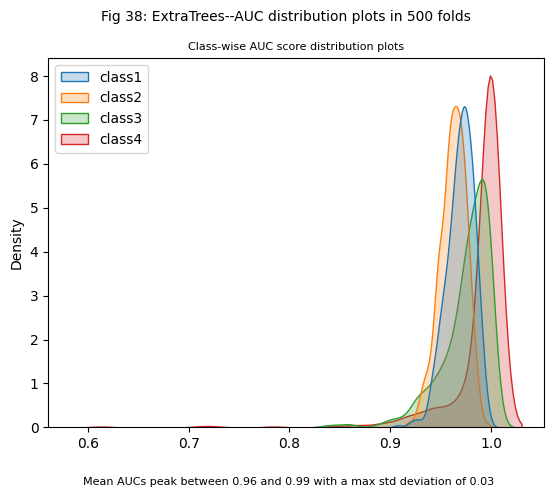

In [ ]:
# AUC distribution plots--500 folds (Extratrees)
_=sns.kdeplot(classwise_roc, fill=True)
_=plt.suptitle("Fig 38: ExtraTrees--AUC distribution plots in 500 folds ", ha="center", fontsize=10)
_=plt.title("Class-wise AUC score distribution plots", ha="center", fontsize=8)
min = np.round(np.min(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
max = np.round(np.max(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
maxsd = np.round(np.max(all_roc_auc_array.reshape(500,4).std(axis=0)),2)
_=plt.figtext(0.5, -0.01, f"Mean AUCs peak between {min} and {max} with a max std deviation of {maxsd}",
              ha="center",
              fontsize=8)
_=plt.show()

#### Class-wise AUC plots

>Class-wise AUC plots. The metrics/data in the following cell is from the last iteration of Repeated StratifiedKFold.      
For class-wise plotting of AUC curves, please refer [StackOverflow](https://stackoverflow.com/q/70278059/3282777)

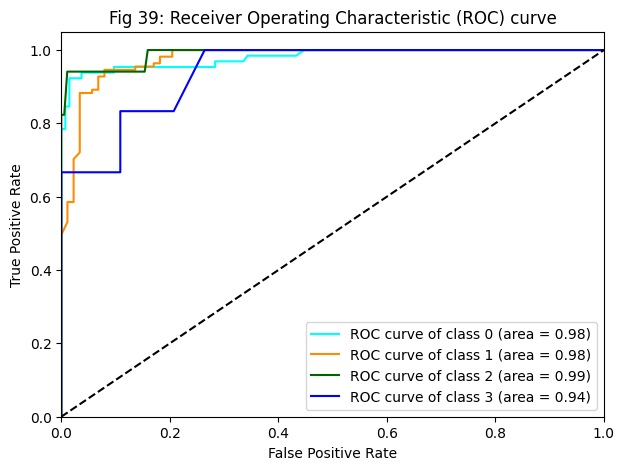

In [ ]:
# Compute ROC curve and ROC area for each class
# Ref: https://stackoverflow.com/q/70278059/3282777

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this point
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

# Plot class-wise ROC curves
_=plt.figure(figsize=(7,5))
colors = cycle(["aqua", "darkorange", "darkgreen",  "blue"])
for i, color in zip(range(n_classes), colors):
  _=plt.plot(fpr[i], tpr[i], color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

_=plt.plot([0, 1], [0, 1], "k--")
_=plt.xlim([0.0, 1.0])
_=plt.ylim([0.0, 1.05])
_=plt.xlabel("False Positive Rate")
_=plt.ylabel("True Positive Rate")
_=plt.title("Fig 39: Receiver Operating Characteristic (ROC) curve")
_=plt.legend()

#### Accuracy scores (extratrees)


In [ ]:
# Mean accuracy scores over CV trials (extratrees)
print("===ExtraTrees=====")
acc_array['extratrees'] = np.array(total_acc_list).flatten()

===ExtraTrees=====


In [ ]:
print("Mean Accuracy                  :", np.mean(acc_array['extratrees']))
print("Median Accuracy                :", np.median(acc_array['extratrees']))
print("Std deviation of accuracy      :", np.std(acc_array['extratrees']))
print("Class-wise avg AUC score       :", all_roc_auc_array.reshape(500,4).mean(axis=0))
print("Class-wise avg std dev of AUCs :", all_roc_auc_array.reshape(500,4).std(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

Mean Accuracy                  : 0.9082086432160804
Median Accuracy                : 0.91
Std deviation of accuracy      : 0.021790868296203744
Class-wise avg AUC score       : [0.96900776 0.96170823 0.97452111 0.98789785]
Class-wise avg std dev of AUCs : [0.01373876 0.0131375  0.02543729 0.03474594]
(for classes 1,2,3,4 respectively)


#### Distribution plot for accuracy (ExtraTrees)


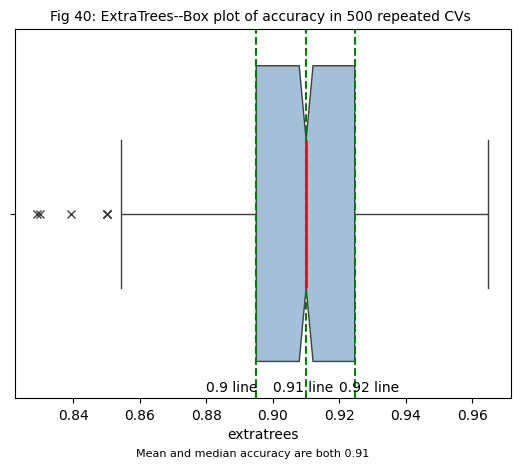

In [ ]:
# Accuracy box plot. How accuracy varies over CV trials (extratrees)
_=plt.title("Fig 40: ExtraTrees--Box plot of accuracy in 500 repeated CVs ", ha="center", fontsize=10)
ax=sns.boxplot(
            data=acc_array, x="extratrees",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )

pts = np.quantile(acc_array['extratrees'], [0.25,0.5,0.75])

_=ax.axvline(x=pts[0], color='g', linestyle='--')
_=ax.axvline(x=pts[1], color='g', linestyle='--')
_=ax.axvline(x=pts[2], color='g', linestyle='--')  # 75% obs above this line

_=ax.text(0.88,0.48, f"{np.round(pts[0],2)} line")
_=ax.text(0.90,0.48, f"{np.round(pts[1],2)} line")
_=ax.text(0.92,0.48, f"{np.round(pts[2],2)} line")

_=plt.figtext(0.5, -0.01, f"Mean and median accuracy are both {np.round(pts[1],2)} ",
              ha="center",
              fontsize=8)
_=plt.show()

#### logloss (ExtraTrees Classifier)

In [ ]:
print("===extratrees=====")
logloss_array['extratrees'] = np.array(total_ll_list).flatten()

===extratrees=====


In [ ]:
print("Overall mean logloss          :", np.mean(logloss_array['extratrees']))
print("Median logloss                :", np.median(logloss_array['extratrees']))
print("Std deviation of logloss      :", np.std(logloss_array['extratrees']))
print("========")

Overall mean logloss          : 0.416763525500028
Median logloss                : 0.41557198283558117
Std deviation of logloss      : 0.14054421071194223


#### precision/recall/f1 scores (ExtraTrees modeling)

In [ ]:
# Classification scores (extratrees)
classification_scores = np.array(total_class0)

# Unlist the list
res =  [x for sublist in classification_scores for x in sublist]
classification_array['extratrees'] = res

In [ ]:
# 'Explode' the list into columns
metricswise_classification_scores = classification_array['extratrees'].apply(pd.Series)

# Rename the columns
metricswise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
print("======")
print(f"Mean classification scores\n\n{metricswise_classification_scores.mean()}")
print("======")
print("")
print(f"Std Dev of classification scores\n\n{metricswise_classification_scores.std()}")
print("======")


Mean classification scores

precision     0.901307
recall        0.886759
f1-score      0.893048
support      64.800000
dtype: float64

Std Dev of classification scores

precision    0.039142
recall       0.045671
f1-score     0.031818
support      0.400401
dtype: float64


#### precision/recall/f1 scores distribution plots (extratrees)

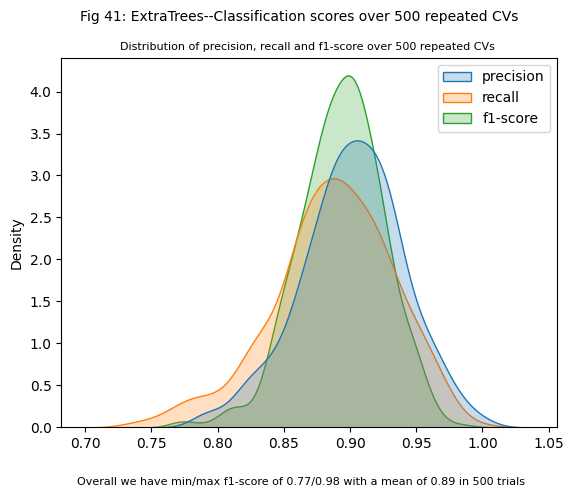

In [ ]:
# Classification score distribution plots--500 in 500 repeated CVs (extratrees))
_=sns.kdeplot(metricswise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle("Fig 41: ExtraTrees--Classification scores over 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Distribution of precision, recall and f1-score over 500 repeated CVs ", ha="center", fontsize=8)
f1_min = np.round(metricswise_classification_scores['f1-score'].min(),2)
f1_max = np.round(metricswise_classification_scores['f1-score'].max(),2)
f1_mean= np.round(metricswise_classification_scores['f1-score'].mean(),2)
_=plt.figtext(0.5, -0.01, f"Overall we have min/max f1-score of {f1_min}/{f1_max} with a mean of {f1_mean} in 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

#### Save to gdrive

In [ ]:
acc_array.to_pickle(acc_array_path)
roc_array.to_pickle(roc_array_path)
classification_array.to_pickle(classification_array_path)
logloss_array.to_pickle(logloss_array_path)

# Save extratrees model also
with open(classifier_path + "extratrees.pkl", "wb") as f:
    dump(extra_classifier, f, protocol=5)

# Along with encoder
with open(classifier_path + "encoder.pkl", "wb") as f:
    dump(encoder, f, protocol=5)

##### Read back

In [ ]:
if os.path.exists(acc_array_path ):
    acc_array = pd.read_pickle(acc_array_path)

if os.path.exists(roc_array_path):
    roc_array = pd.read_pickle(roc_array_path)

if os.path.exists(classification_array_path):
    classification_array = pd.read_pickle(classification_array_path)

if os.path.exists(logloss_array_path):
    logloss_array = pd.read_pickle(logloss_array_path)

with open(classifier_path + "extratrees.pkl", "rb") as f:
    extra_classifier = load(f)

with open(classifier_path + "encoder.pkl", "rb") as f:
    encoder = load(f)

##### Check

In [ ]:
## Check if data retrieved
print("Accuracy")
acc_array.head(2)
print("AUC")
roc_array.head(2)
print("Classification metrics")
classification_array.head(2)
print("logloss")
logloss_array.head(2)

print("extra Classifier")
extra_classifier
print("Preprocessor encoder")
encoder

Accuracy


,randomforest,histclassifier,extratrees,xgbclf
0,0.880,0.855,0.930,0.895
1,0.865,0.900,0.895,0.855


AUC


,randomforest,histclassifier,extratrees,xgbclf
0,"[0.9594871794871794, 0.9632203733766234, 0.991...","[0.9187464387464388, 0.9074675324675325, 0.903...","[0.9616524216524217, 0.962104301948052, 0.9962...","[0.9496296296296297, 0.9437905844155844, 0.948..."
1,"[0.9775965073529412, 0.9710328733766234, 0.990...","[0.9698988970588235, 0.9694602272727273, 0.981...","[0.9794921875, 0.9686485389610389, 0.994214079...","[0.9379595588235293, 0.9212662337662336, 0.974..."


Classification metrics


,randomforest,histclassifier,extratrees,xgbclf
0,"[0.8888888888888888, 0.8615384615384616, 0.875...","[0.875, 0.7538461538461538, 0.8099173553719008...","[0.9230769230769231, 0.9230769230769231, 0.923...","[0.8870967741935484, 0.8461538461538461, 0.866..."
1,"[0.8412698412698413, 0.828125, 0.8346456692913...","[0.875, 0.875, 0.875, 64.0]","[0.8769230769230769, 0.890625, 0.8837209302325...","[0.8115942028985508, 0.875, 0.8421052631578947..."


logloss


,randomforest,histclassifier,extratrees,xgbclf
0,0.384165,1.004075,0.581464,0.346389
1,0.367272,0.444468,0.427307,0.393817


extra Classifier


ExtraTreesClassifier(criterion='entropy', n_estimators=400, n_jobs=-1)

Preprocessor encoder


CatBoostEncoder(cols=['sex', 'edentulous', 'mouth opening',
                      'head and neck movement'])

#### Permutation feature importance
Refer [here](https://scikit-learn.org/stable/modules/permutation_importance.html) AND [here](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

>Permutation feature importance is a model-agnostic technique used to assess the contribution of individual features to a machine learning model's predictive performance. It works with any supervised learning algorithm. It measures how much a model's performance degrades when a specific feature's values are randomly shuffled, breaking its relationship with the target variable. A larger performance drop indicates higher importance for that feature. BAsic steps are:


>>1. Train the model and evaluate its baseline performance (e.g., accuracy, RMSE) on a held-out dataset.
>>2. Shuffle one feature while keeping others unchanged, then recompute performance.
>>3. Compare performance between the original and shuffled scenarios to calculate importance.
4. Repeat for all features and multiple permutations to reduce variance.

Its one limitation is that it importance scores reflect a specific model-dataset pairing, not intrinsic feature value.


In [ ]:
# Splitting the dataset into test & train
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    stratify= y)

# Our Extratrees model
clf = ExtraTreesClassifier(criterion="entropy",
                           n_estimators=400,
                           max_depth=None,
                           min_samples_split=2,
                           warm_start=False
                           )
clf.fit(X_train, y_train)

# Calculate permutation importance with test data
# We permute each feature 40 times
etr = permutation_importance(clf,
                             X_test, y_test,
                             n_repeats=40  # Permute 40 times each feature
                             )




ExtraTreesClassifier(criterion='entropy', n_estimators=400)

In [ ]:
# Data collectors
# Feature names
cols = []
# Feature impt
etr_mean = []
# Feature impt std dev
etr_std = []

print("Extent of degradation of accuracy score")
print("=======================================\n")
for i in etr.importances_mean.argsort()[::-1]:
    if etr.importances_mean[i] - 2 * etr.importances_std[i] > 0:
        print(f"{X.columns[i]:<13}\t\t\t"
              f"{etr.importances_mean[i]:.3f}"
              f" +/- {etr.importances_std[i]:.3f}")
        cols.append(X.columns[i])
        etr_mean.append(np.round(etr.importances_mean[i],2))
        etr_std.append(np.round(etr.importances_std[i],2))
print("===============")

Extent of degradation of accuracy score

mallampatti  			0.188 +/- 0.024
age          			0.104 +/- 0.017
bmi          			0.080 +/- 0.011
sex          			0.075 +/- 0.018
thyromental distance			0.065 +/- 0.015
buck teeth   			0.054 +/- 0.012
height       			0.050 +/- 0.012
sternomental distance			0.046 +/- 0.012
edentulous   			0.043 +/- 0.011
subluxation of mandible			0.041 +/- 0.010
head and neck movement			0.036 +/- 0.008


In [ ]:
# Tabulate above results
# Ref: https://pypi.org/project/tabulate/
from tabulate import tabulate
table = [cols, etr_mean, etr_std]
print("                                                       Extent of degradation of accuracy score")
print(tabulate(table, showindex = ["cols=>", "mean", "std"], tablefmt = 'grid'))

                                                       Extent of degradation of accuracy score
+--------+-------------+------+------+------+----------------------+------------+--------+-----------------------+------------+-------------------------+------------------------+
| cols=> | mallampatti | age  | bmi  | sex  | thyromental distance | buck teeth | height | sternomental distance | edentulous | subluxation of mandible | head and neck movement |
+--------+-------------+------+------+------+----------------------+------------+--------+-----------------------+------------+-------------------------+------------------------+
| mean   | 0.19        | 0.1  | 0.08 | 0.07 | 0.06                 | 0.05       | 0.05   | 0.05                  | 0.04       | 0.04                    | 0.04                   |
+--------+-------------+------+------+------+----------------------+------------+--------+-----------------------+------------+-------------------------+------------------------+
| std    |

##### Plot feature importance

In [ ]:
# Plot function for permutation importance
# Ref: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

def plot_permutation_importance(etr, X, y, ax):
    perm_sorted_idx = etr.importances_mean.argsort()
    tick_labels_dict = {"tick_labels": X.columns[perm_sorted_idx]}
    ax.boxplot(etr.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

<Axes: >

<Axes: >

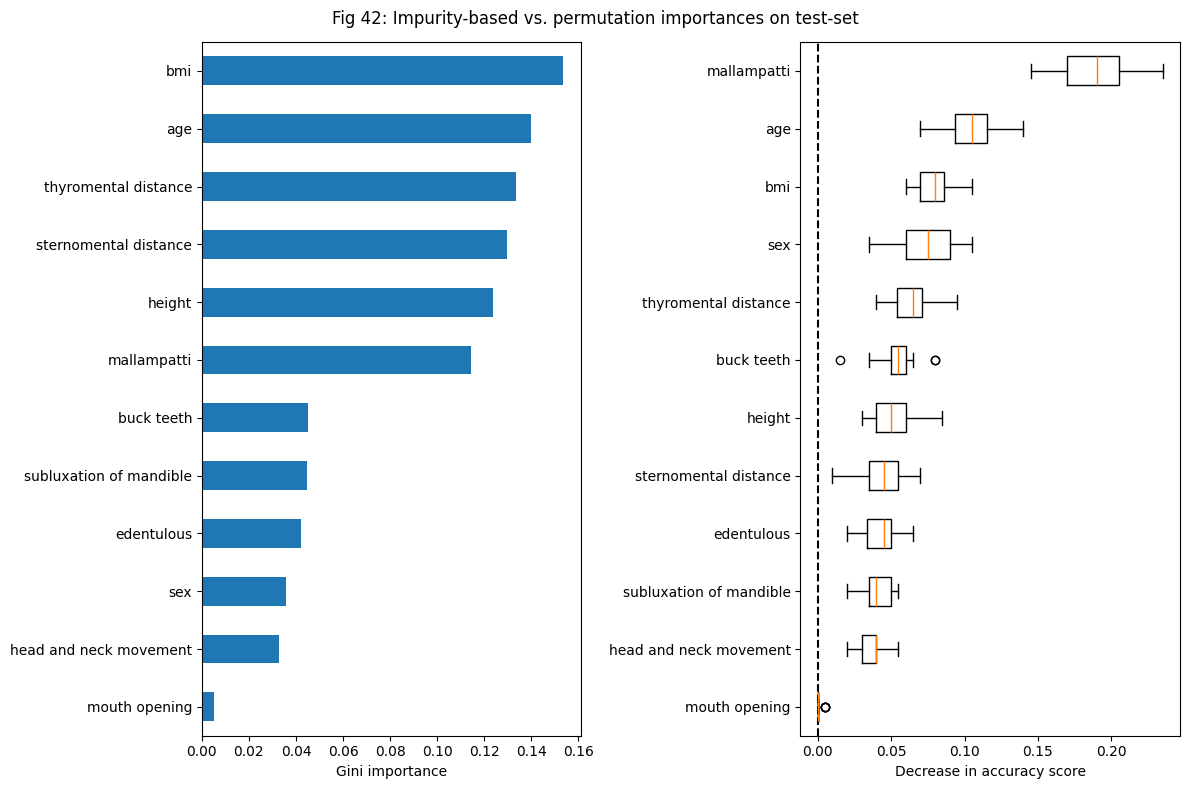

In [ ]:
# Plot impurity based and permutaion based importances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Impurity based importance plot
mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
mdi_importances.sort_values().plot.barh(ax=ax1)
_=ax1.set_xlabel("Gini importance")

# Permutation importance plot
plot_permutation_importance(etr, X_test, y_test, ax2)
_=ax2.set_xlabel("Decrease in accuracy score")

_=fig.suptitle(
    "Fig 42: Impurity-based vs. permutation importances on test-set"
)
_ = fig.tight_layout()

### XGBoost classifier

#### Hyperparameter search

In [ ]:
%%time



# Took 30 minutes
# Search for the best xgboost parameters using Randomized cv search

xgb_classifier = XGBClassifier(
                                objective='binary:logistic',
                                eval_metric = accuracy_score,
                                n_jobs = 16
                               )

# Consider these parameters:
param_grid = {
              "booster" : ['gbtree', 'dart', 'gblinear'],
              "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
              "n_estimators" : [200, 250,300,350],
              "max_depth" : [3,4,5,6,7,8,9],
              "grow_policy" : ['depthwise', 'lossguide'],
              "colsample_bytree" : [0.5,0.7,0.9,1.0],
              "reg_lambda": loguniform(1e-4, 1e-2),
              "reg_alpha" : loguniform(1e-4, 1e-2),
              "gamma" : loguniform(1e-4, 1e-2),
             }

# Evaluate over 100 points in the search space
# Best fitted model is returned
model_random_search = RandomizedSearchCV(xgb_classifier,
                                         param_distributions=param_grid,
                                         n_jobs=-1,
                                         n_iter = 100,  # Look at 100 pts
                                         cv=5,
                                         verbose=1   # Show progress
                                        )


model_random_search.fit(X_train, y_train)
xgb_bst_param= model_random_search.best_params_
xgb_bst_param

CPU times: user 1min 43s, sys: 5.6 s, total: 1min 49s
Wall time: 1h 19min 9s


{'booster': 'dart',
 'colsample_bytree': 0.9,
 'gamma': np.float64(0.003954038661298285),
 'grow_policy': 'depthwise',
 'learning_rate': 0.05,
 'max_depth': 7,
 'n_estimators': 300,
 'reg_alpha': np.float64(0.0004317759184976679),
 'reg_lambda': np.float64(0.0016423427819499588)}

#### Best fitted model's performance

In [ ]:
# Best fitted model's performance:

# 1. Accuracy
print(f"1. Accuracy {model_random_search.score(X_test,y_test)}")  # 0.8592964824120602
# 2. Class-wise AUC
print(f"2. class-wise AUC {roc_auc_score(y_test, model_random_search.predict_proba(X_test), multi_class='ovr', average = None)}")
# 3. logloss
print(f"3. Logloss: {log_loss(y_test, model_random_search.predict_proba(X_test))}")
# 4. Classificatio reports
print(f"4. Classification report\n: {classification_report(y_test,model_random_search.predict(X_test))}")

1. Accuracy 0.9798994974874372
2. class-wise AUC [0.99862227 0.9987715  0.99806076 1.        ]
3. Logloss: 0.08743477435569968
4. Classification report
:               precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.97      1.00      0.98       111
           2       1.00      0.88      0.94        17
           3       1.00      1.00      1.00         6

    accuracy                           0.98       199
   macro avg       0.99      0.96      0.98       199
weighted avg       0.98      0.98      0.98       199



#### Repeated StratifiedKFold

In [ ]:
# From hyperparameter search:

booster =  'dart'
colsample_bytree = 0.9
gamma = 0.003954038661298285
grow_policy = 'depthwise'
learning_rate = 0.05
max_depth = 7
n_estimators = 300
reg_alpha = 0.0004317759184976679
reg_lambda = 0.0016423427819499588

In [ ]:
%%time

import time

clf = XGBClassifier(booster = booster,
                        max_depth = max_depth,
                        n_estimators=n_estimators,
                        grow_policy = grow_policy,
                        colsample_bytree = colsample_bytree,
                        reg_lambda = reg_lambda,
                        reg_alpha = reg_alpha,
                        gamma = gamma,
                        learning_rate = learning_rate,
                        objective='binary:logistic',
                        n_jobs = -1
                        )


n = 50
# Store (cormack lehane) classwise classification-report
# over all n-repeated 5-fold n_splits:
total_class0 = []  # [class0] * n
total_class1 = []  # [[['precision', 'recall', 'f1-score', 'support'] * n_splits ] *n]
total_class2 = []  # [class2] * n
total_class3 = []  # [class3] * n
# To store, class-wise roc-data, for n attempts
all_roc_auc = []
# To store accuracy data for n attempts
total_acc_list = []
# To store logloss data for n attempts
total_ll_list = []
count = 1

print("==******************************************" )
print(f"Total number of folds would be: {n * 5}" )
print("==******************************************\n\n" )

# We take 5-random folds n times
for i in range(n):
  start = time.time()
  # To store accuracy data averaged over all classes
  list_accu_stratified = []
  # To store logloss
  list_ll_stratified = []
  # Class-wise roc-data for each of the classes for five folds
  list_roc_auc = []
  # Classwise classification report per cross-validation
  class0 = []  # class0: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class1 = []  # class1: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class2 = []  # class2: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class3 = []  # class3: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]

  # Get Stratified K-Fold cross-validator object
  skf = StratifiedKFold(
                        n_splits=5,
                        shuffle=True
                        )

  # Iterate 5-times ie once per split/fold
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]  # y is label encoded
      print("=======")
      print("fold:", count ) ; count = count +1
      if (i < 1):
        print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Use X_train, X_test, y_train, y_test to train/evaluate model in each fold
      clf.fit(X_train, y_train)

      # 1. Get accuracy in this particular split (but averaged over all classes)
      acc = clf.score(X_test, y_test)
      print("Accuracy for this fold/split averaged over all the classes:", acc)
      list_accu_stratified.append(acc)

      # 2. Get class-wise AUC scores:
      # ovr==>One-vs-rest auc
      auc_class = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr', # Ref: https://stackoverflow.com/a/66022487
                          average = None)

      print("Class-wise AUC for this fold/split:", auc_class)
      list_roc_auc.append(auc_class)

      # 3. Classification report: precision/f1/recall/support
      sk = classification_report(y_test,
                                 clf.predict(X_test),
                                 output_dict = True  # dict format and not tabular format
                                 )
      # sk['0'].values(): ['precision', 'recall', 'f1-score', 'support']
      #                   for class-0 of cormack lehane
      class0.append(list(sk['0'].values()))
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

      # 4.0 log_loss
      prob = clf.predict_proba(X_test)
      ll = log_loss(y_test, prob)
      print("logloss for this fold/split:", ll)
      list_ll_stratified.append(ll)

  total_acc_list.append(list_accu_stratified)
  total_ll_list.append(list_ll_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)
  print(f"Mean accuracy over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_acc_list).flatten())}")
  print(f"Mean logloss over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_ll_list).flatten())}")
  end = time.time()
  print(f"Time taken for five folds: {(end-start)/60} min")

xgb_classifier = clf


In [ ]:
# Just check shapes of our metrics collectors
# n_splits: 5
# Repeated n_splits: n
# No of classes: 4
# No of classification scores: 4 (precision/recall/f1/support)

# 1. Classification reports
np.array(class0).shape                 # (5x4)       [For everyone of n_splits, one report]
np.array(total_class0).shape           # (n, 5, 4)
# 2. AUC
np.array(list_roc_auc).shape           # (5X4)       [For everyone of n_splits, AUC over all 4 classes]
np.array(all_roc_auc).shape            # (n, 5, 4)
# 3. Accuracy
np.array(list_accu_stratified).shape   # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_acc_list).shape         # (n,5)
# 4. logloss
np.array(list_ll_stratified).shape     # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_ll_list).shape          # (n,5)

#### AUC scores (xgbclf)

In [ ]:
# AUC data compilation (xgbclassifier)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("XGb Classifier--Class-wise mean of AUCs:    " ,all_roc_auc_array.reshape(n*5,4).mean(axis=0))
# Class-wise std dev of AUCs
print("XGb Classifier--Class-wise std devs of AUCs:" ,all_roc_auc_array.reshape(n*5,4).std(axis=0))

(50, 5, 4)

XGb Classifier--Class-wise mean of AUCs:     [0.94782711 0.93397617 0.9368862  0.98002073]
XGb Classifier--Class-wise std devs of AUCs: [0.01830548 0.0199363  0.05231129 0.04212317]


#### AUC distribution (xgbclf)

In [ ]:
# Classwise AUCs in nX5 iterations (xgbclassifier)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['xgbclf'] = pd.Series(res)

In [ ]:
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['xgbclf'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
print("              Class-wise AUCs")
classwise_roc.head()

              Class-wise AUCs


,class1,class2,class3,class4
0,0.978575,0.968649,0.998302,0.991858
1,0.952665,0.924817,0.900032,0.985196
2,0.924444,0.903229,0.962713,0.996299
3,0.948737,0.945792,0.967356,1.000000
4,0.928932,0.925880,0.966063,0.998273


#### Accuracy scores (xgbclassifier)

In [ ]:
# Mean accuracy scores over CV trials (xgbclassifier)
print("===XGBoost Classifier=====")
acc_array['xgbclf'] = pd.Series(np.array(total_acc_list).flatten())

===XGBoost Classifier=====


In [ ]:
print("Mean Accuracy                  :", np.mean(acc_array['xgbclf']))
print("Median Accuracy                :", np.nanmedian(acc_array['xgbclf']))
print("Std deviation of accuracy      :", np.std(acc_array['xgbclf']))
print("Class-wise avg AUC score       :", all_roc_auc_array.reshape(n * 5,4).mean(axis=0))
print("Class-wise avg std dev of AUCs :", all_roc_auc_array.reshape(n * 5,4).std(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

Mean Accuracy                  : 0.8693181909547739
Median Accuracy                : 0.87
Std deviation of accuracy      : 0.02276866706982122
Class-wise avg AUC score       : [0.94782711 0.93397617 0.9368862  0.98002073]
Class-wise avg std dev of AUCs : [0.01830548 0.0199363  0.05231129 0.04212317]
(for classes 1,2,3,4 respectively)


#### Distribution plot of accuracy (xgboost classifier)

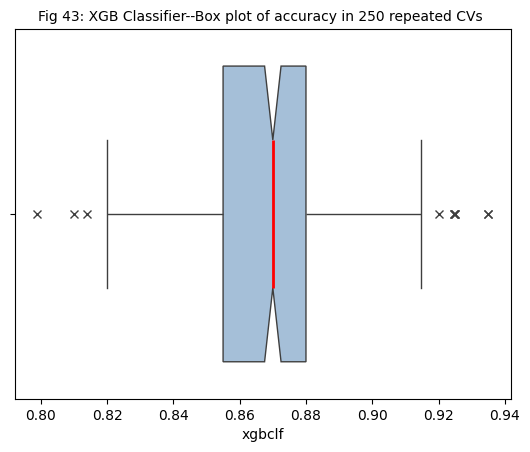

In [ ]:
# Accuracy box plot. How accuracy varies over CV trials (xgbclassifier)
_=plt.title(f"Fig 43: XGB Classifier--Box plot of accuracy in {n * 5} repeated CVs ",
            ha="center",
            fontsize=10)

ax=sns.boxplot(
            data=acc_array, x="xgbclf",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )


#### logloss (XGB Classifier)

In [ ]:
print("===xgbclassifier=====")
logloss_array['xgbclf'] = pd.Series(np.array(total_ll_list).flatten())

===xgbclassifier=====


In [ ]:
print("Overall mean logloss          :", np.mean(logloss_array['xgbclf']))
print("Median logloss                :", np.nanmedian(logloss_array['xgbclf']))
print("Std deviation of logloss      :", np.std(logloss_array['xgbclf']))
print("========")

Overall mean logloss          : 0.4117713845894431
Median logloss                : 0.4082911862794012
Std deviation of logloss      : 0.07188094297173225


#### precision/recall/f1 scores (XGBClassifier)

In [ ]:
# Classification scores (xgbclassifier)
classification_scores = np.array(total_class0)

# Unlist the list
res =  [x for sublist in classification_scores for x in sublist]
classification_array['xgbclf'] = pd.Series(res)

In [ ]:
# 'Explode' the list into columns
metricswise_classification_scores = classification_array['xgbclf'].apply(pd.Series)

# Rename the columns
metricswise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
print("======")
print(f"Mean classification scores\n\n{metricswise_classification_scores.mean()}")
print("======")
print("")
print(f"Std Dev of classification scores\n\n{metricswise_classification_scores.std()}")
print("======")


Mean classification scores

precision     0.869915
recall        0.835114
f1-score      0.850901
support      64.800000
dtype: float64

Std Dev of classification scores

precision    0.044705
recall       0.047332
f1-score     0.032796
support      0.400802
dtype: float64


#### precision/recall/f1 scores distribution plots (xgbclassifier)

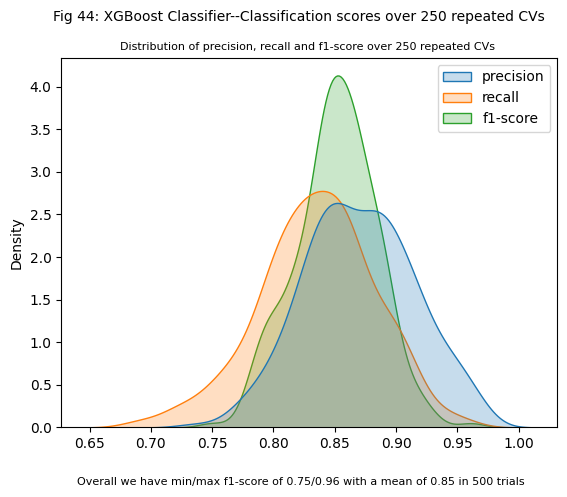

In [ ]:
# Classification score distribution plots--500 in 500 repeated CVs (xgbclassifier)
_=sns.kdeplot(metricswise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle(f"Fig 44: XGBoost Classifier--Classification scores over {n * 5} repeated CVs ", ha="center", fontsize=10)
_=plt.title(f"Distribution of precision, recall and f1-score over {n * 5} repeated CVs ", ha="center", fontsize=8)
f1_min = np.round(metricswise_classification_scores['f1-score'].min(),2)
f1_max = np.round(metricswise_classification_scores['f1-score'].max(),2)
f1_mean= np.round(metricswise_classification_scores['f1-score'].mean(),2)
_=plt.figtext(0.5, -0.01, f"Overall we have min/max f1-score of {f1_min}/{f1_max} with a mean of {f1_mean} in 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

#### Save to gdrive

In [ ]:
acc_array.to_pickle(acc_array_path)
roc_array.to_pickle(roc_array_path)
classification_array.to_pickle(classification_array_path)
logloss_array.to_pickle(logloss_array_path)

# xgboost_classifier
with open(classifier_path + "xgb.pkl", "wb") as f:
    dump(xgb_classifier, f, protocol=5)

##### Read back

In [ ]:
if os.path.exists(acc_array_path ):
    acc_array = pd.read_pickle(acc_array_path)

if os.path.exists(roc_array_path):
    roc_array = pd.read_pickle(roc_array_path)

if os.path.exists(classification_array_path):
    classification_array = pd.read_pickle(classification_array_path)

if os.path.exists(logloss_array_path):
    logloss_array = pd.read_pickle(logloss_array_path)

with open(classifier_path + "xgb.pkl", "rb") as f:
    xgb_classifier = load(f)

##### Check

In [ ]:
## Check if data retrieved
print("Accuracy")
acc_array.head(2)
print("AUC")
roc_array.head(2)
print("Classification metrics")
classification_array.head(2)
print("logloss")
logloss_array.head(2)
print("XGBoost classifier")
xgb_classifier

Accuracy


,randomforest,histclassifier,extratrees,xgbclf
0,0.880,0.855,0.930,0.925
1,0.865,0.900,0.895,0.850


AUC


,randomforest,histclassifier,extratrees,xgbclf
0,"[0.9594871794871794, 0.9632203733766234, 0.991...","[0.9187464387464388, 0.9074675324675325, 0.903...","[0.9616524216524217, 0.962104301948052, 0.9962...","[0.9785754985754985, 0.968648538961039, 0.9983..."
1,"[0.9775965073529412, 0.9710328733766234, 0.990...","[0.9698988970588235, 0.9694602272727273, 0.981...","[0.9794921875, 0.9686485389610389, 0.994214079...","[0.9526654411764706, 0.9248173701298702, 0.900..."


Classification metrics


,randomforest,histclassifier,extratrees,xgbclf
0,"[0.8888888888888888, 0.8615384615384616, 0.875...","[0.875, 0.7538461538461538, 0.8099173553719008...","[0.9230769230769231, 0.9230769230769231, 0.923...","[0.9516129032258065, 0.9076923076923077, 0.929..."
1,"[0.8412698412698413, 0.828125, 0.8346456692913...","[0.875, 0.875, 0.875, 64.0]","[0.8769230769230769, 0.890625, 0.8837209302325...","[0.8983050847457628, 0.828125, 0.8617886178861..."


logloss


,randomforest,histclassifier,extratrees,xgbclf
0,0.384165,1.004075,0.581464,0.252733
1,0.367272,0.444468,0.427307,0.516338


XGBoost classifier


XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.003954038661298285, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

## Quick summary
>As all the results are saved on gdrive, you can simply begin from here, instead of executing the complete notebook. We only need two libraries--pandas and numpy.





### Connect to google drive
Connect to gdrive if not connected

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


#### Read back saved data/estimators

In [ ]:
import pandas as pd
import numpy as np
from pickle import load
import os

In [ ]:
# Write file paths
acc_array_path = '/gdrive/MyDrive/airways/acc_array.pkl'
roc_array_path = '/gdrive/MyDrive/airways/roc_array.pkl'
classification_array_path = '/gdrive/MyDrive/airways/classification_array.pkl'
logloss_array_path = '/gdrive/MyDrive/airways/logloss_array.pkl'
classifier_path = '/gdrive/MyDrive/airways/'

In [ ]:
if os.path.exists(acc_array_path ):
    acc_array = pd.read_pickle(acc_array_path)

if os.path.exists(roc_array_path):
    roc_array = pd.read_pickle(roc_array_path)

if os.path.exists(classification_array_path):
    classification_array = pd.read_pickle(classification_array_path)

if os.path.exists(logloss_array_path):
    logloss_array = pd.read_pickle(logloss_array_path)

In [ ]:
# Read back estimators
# Random forest
with open(classifier_path+ "randomForest_classifier.pkl", "rb") as f:
    randomForest_classifier = load(f)

# hist_classifier
with open(classifier_path+ "hist_classifier.pkl", "rb") as f:
    hist_classifier = load(f)

# Extra trees
with open(classifier_path + "extratrees.pkl", "rb") as f:
    extra_classifier = load(f)

with open(classifier_path + "encoder.pkl", "rb") as f:
    encoder = load(f)

# XGboost classifier

with open(classifier_path + "xgb.pkl", "rb") as f:
    xgb_classifier = load(f)

##### Check

In [ ]:
## Check if data retrieved
acc_array.head(2)
roc_array.head(2)
classification_array.head(2)
logloss_array.head(2)

# Classifiers retrieved
randomForest_classifier
hist_classifier
extra_classifier
encoder
xgb_classifier

,randomforest,histclassifier,extratrees,xgbclf
0,0.840,0.855,0.930,0.925
1,0.865,0.900,0.895,0.850


,randomforest,histclassifier,extratrees,xgbclf
0,"[0.9384615384615385, 0.9190848214285715, 0.959...","[0.9187464387464388, 0.9074675324675325, 0.903...","[0.9616524216524217, 0.962104301948052, 0.9962...","[0.9785754985754985, 0.968648538961039, 0.9983..."
1,"[0.9415211397058824, 0.9394277597402597, 0.996...","[0.9698988970588235, 0.9694602272727273, 0.981...","[0.9794921875, 0.9686485389610389, 0.994214079...","[0.9526654411764706, 0.9248173701298702, 0.900..."


,randomforest,histclassifier,extratrees,xgbclf
0,"[0.8947368421052632, 0.7846153846153846, 0.836...","[0.875, 0.7538461538461538, 0.8099173553719008...","[0.9230769230769231, 0.9230769230769231, 0.923...","[0.9516129032258065, 0.9076923076923077, 0.929..."
1,"[0.8548387096774194, 0.828125, 0.8412698412698...","[0.875, 0.875, 0.875, 64.0]","[0.8769230769230769, 0.890625, 0.8837209302325...","[0.8983050847457628, 0.828125, 0.8617886178861..."


,randomforest,histclassifier,extratrees,xgbclf
0,0.464156,1.004075,0.581464,0.252733
1,0.416657,0.444468,0.427307,0.516338


RandomForestClassifier(criterion='entropy', n_estimators=400)

HistGradientBoostingClassifier(categorical_features=['sex', 'buck teeth',
                                                     'edentulous',
                                                     'mallampatti',
                                                     'mouth opening',
                                                     'subluxation of mandible',
                                                     'head and neck movement'],
                               l2_regularization=0.0008765786227423513,
                               max_features=0.8, max_iter=300,
                               max_leaf_nodes=45, min_samples_leaf=15)

ExtraTreesClassifier(criterion='entropy', n_estimators=400, n_jobs=-1)

CatBoostEncoder(cols=['sex', 'edentulous', 'mouth opening',
                      'head and neck movement'])

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.003954038661298285, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

### Accuracy and logloss
Mean and Median

In [ ]:
# Get means/medians/std deviations
# Each one of these is pandas Series object

print(f"Mean of accuracies (sorted): \n\n{acc_array.mean(skipna = True,axis = 0).sort_values()}")
print("====\n")
print(f"Std dev of accuracies (sorted): \n\n{acc_array.std(skipna = True,axis = 0).sort_values()}")
print("====\n")
print(f"Logloss (sorted): \n\n{logloss_array.mean(skipna = True,axis = 0).sort_values()}")
print("====\n")
print(f"Std Dev of logloss (sorted): \n\n{logloss_array.std(skipna = True,axis = 0).sort_values()}")
print("====\n")
print(f"Median of accuracies (sorted): \n\n{acc_array.median(skipna = True,axis = 0).sort_values()}")
print("====\n")


Mean of accuracies (sorted): 

xgbclf            0.869318
randomforest      0.881826
histclassifier    0.888078
extratrees        0.908209
dtype: float64
====

Std dev of accuracies (sorted): 

extratrees        0.021813
xgbclf            0.022814
randomforest      0.022814
histclassifier    0.023002
dtype: float64
====

Logloss (sorted): 

xgbclf            0.411771
extratrees        0.416764
randomforest      0.417780
histclassifier    0.673380
dtype: float64
====

Std Dev of logloss (sorted): 

randomforest      0.070067
xgbclf            0.072025
extratrees        0.140685
histclassifier    0.187504
dtype: float64
====

Median of accuracies (sorted): 

xgbclf            0.870000
randomforest      0.884422
histclassifier    0.889447
extratrees        0.910000
dtype: float64
====



In [ ]:
# Concat these Series into one pandas DataFrame
# With netrics as column names
metrics  = pd.DataFrame({'Mean accuracy' : np.array(acc_array.mean(skipna = True,axis = 0)),
                         'Median accuracy' : np.array(acc_array.median(skipna = True,axis = 0)),
                         'stdDev mean' : acc_array.std(skipna = True,axis = 0),
                         'Mean logloss' : logloss_array.mean(skipna = True,axis = 0),
                         'stdDev logloss' : logloss_array.std(skipna = True,axis = 0)
                         })

# Transpose. Estimators are now column names
metrics = metrics.T
metrics = metrics.rename(columns={'randomforest': 'RandomForest',
                                  'histclassifier' : "HistGradientBoosting",
                                  'extratrees': 'ExtraTrees',
                                  'xgbclf' : 'XGBoost'}
                         ).T
metrics.sort_values(by='Mean accuracy',ascending = False, inplace = True)

print()
print("                                                Accuracy and Logloss")
print("                                                (Over multiple folds)")
metrics
print()


                                                Accuracy and Logloss
                                                (Over multiple folds)


,Mean accuracy,Median accuracy,stdDev mean,Mean logloss,stdDev logloss
ExtraTrees,0.908209,0.910000,0.021813,0.416764,0.140685
HistGradientBoosting,0.888078,0.889447,0.023002,0.673380,0.187504
RandomForest,0.881826,0.884422,0.022814,0.417780,0.070067
XGBoost,0.869318,0.870000,0.022814,0.411771,0.072025


### AUC
auc scores

In [ ]:
# xgbclf
classwise_roc = roc_array['xgbclf'].apply(pd.Series)
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
xgbclf = classwise_roc.mean()
xgbclf.name = "XGBoosting"
# randomforest
classwise_roc = roc_array['randomforest'].apply(pd.Series)
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
randomforest = classwise_roc.mean()
randomforest.name = "RandomForest"
# extratrees
classwise_roc = roc_array['extratrees'].apply(pd.Series)
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
extratrees = classwise_roc.mean()
extratrees.name = "ExtraTrees"
# histclassifier
classwise_roc = roc_array['histclassifier'].apply(pd.Series)
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
histclassifier = classwise_roc.mean()
histclassifier.name = "HistGradientBoosting"

# Concat these Series into one pandas DataFrame
# With netrics as column names

auc_class = pd.concat([xgbclf, extratrees, randomforest,histclassifier], axis=1).T
auc_class.sort_values(by='class1',ascending = False, inplace = True)

print("                           Class-wise Area Under the Curve")
print("                              (Mean over multiple folds)")
auc_class

                           Class-wise Area Under the Curve
                              (Mean over multiple folds)


,class1,class2,class3,class4
ExtraTrees,0.969008,0.961708,0.974521,0.987898
RandomForest,0.960940,0.951794,0.963498,0.981567
HistGradientBoosting,0.955211,0.945768,0.947801,0.975617
XGBoosting,0.947827,0.933976,0.936886,0.980021


##### Classification metrics
precision/recall/f1_score

In [ ]:
xgbclf_classification_scores = classification_array['xgbclf'].apply(pd.Series)
xgbclf_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
xgbclf_precision = xgbclf_classification_scores['precision']
xgbclf_recall = xgbclf_classification_scores['recall']
xgbclf_f1score = xgbclf_classification_scores['f1-score']

randomforest_classification_scores = classification_array['randomforest'].apply(pd.Series)
randomforest_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
randomforest_precision = randomforest_classification_scores['precision']
randomforest_recall = randomforest_classification_scores['recall']
randomforest_f1score = randomforest_classification_scores['f1-score']

extratrees_classification_scores = classification_array['extratrees'].apply(pd.Series)
extratrees_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
extratrees_precision = extratrees_classification_scores['precision']
extratrees_recall = extratrees_classification_scores['recall']
extratrees_f1score = extratrees_classification_scores['f1-score']

histclassifier_classification_scores = classification_array['histclassifier'].apply(pd.Series)
histclassifier_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
histclassifier_precision = histclassifier_classification_scores['precision']
histclassifier_recall = histclassifier_classification_scores['recall']
histclassifier_f1score = histclassifier_classification_scores['f1-score']

In [ ]:
precision = pd.concat([xgbclf_precision, extratrees_precision, randomforest_precision,histclassifier_precision], axis=1)
precision.columns = ['xgbclf', 'extratrees', 'randomforest','histclassifier']
recall = pd.concat([xgbclf_recall, extratrees_recall, randomforest_recall,histclassifier_recall], axis=1)
recall.columns = ['xgbclf', 'extratrees', 'randomforest','histclassifier']
f1score = pd.concat([xgbclf_f1score, extratrees_f1score, randomforest_f1score,histclassifier_f1score], axis=1)
f1score.columns = ['xgbclf', 'extratrees', 'randomforest','histclassifier']


In [ ]:
precision_score= precision.mean()
recall_score = recall.mean()
f1_score = f1score.mean()
classification_metrics = pd.DataFrame({'precision':precision_score, 'recall':recall_score, 'f1-score':f1_score})
classification_metrics = classification_metrics.T
classification_metrics = classification_metrics.rename(columns={'randomforest': 'RandomForest',
                                                                'histclassifier' : "HistGradientBoosting",
                                                                'extratrees': 'ExtraTrees',
                                                                'xgbclf' : 'XGBoost'
                                                                }
                                                       )

print()
print("                       Mean Classification scores")
print("                          (Over multiple folds)")
classification_metrics
print()



                       Mean Classification scores
                          (Over multiple folds)


,XGBoost,ExtraTrees,RandomForest,HistGradientBoosting
precision,0.869915,0.901307,0.898125,0.878844
recall,0.835114,0.886759,0.845660,0.859971
f1-score,0.850901,0.893048,0.869875,0.868162


In [ ]:
# Here are all at one place
print("                                                At-a-glance")
print("                                                -----------")
print()
print("                                           1. Accuracy and Logloss")
print("                                              (Over multiple folds)")
metrics
print()
print("                           2. Class-wise Area Under the Curve")
print("                                (Mean over multiple folds)")
auc_class
print()
print("                       3. Classification scores")
print("                           (Over multiple folds)")
classification_metrics
print()


                                                At-a-glance
                                                -----------

                                           1. Accuracy and Logloss
                                              (Over multiple folds)


,Mean accuracy,Median accuracy,stdDev mean,Mean logloss,stdDev logloss
ExtraTrees,0.908209,0.910000,0.021813,0.416764,0.140685
HistGradientBoosting,0.888078,0.889447,0.023002,0.673380,0.187504
RandomForest,0.881826,0.884422,0.022814,0.417780,0.070067
XGBoost,0.869318,0.870000,0.022814,0.411771,0.072025



                           2. Class-wise Area Under the Curve
                                (Mean over multiple folds)


,class1,class2,class3,class4
ExtraTrees,0.969008,0.961708,0.974521,0.987898
RandomForest,0.960940,0.951794,0.963498,0.981567
HistGradientBoosting,0.955211,0.945768,0.947801,0.975617
XGBoosting,0.947827,0.933976,0.936886,0.980021



                       3. Classification scores
                           (Over multiple folds)


,XGBoost,ExtraTrees,RandomForest,HistGradientBoosting
precision,0.869915,0.901307,0.898125,0.878844
recall,0.835114,0.886759,0.845660,0.859971
f1-score,0.850901,0.893048,0.869875,0.868162


# <font color="red">========END==========</font>